In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('final_combined_dataset.csv')

# Drop unnecessary columns and ensure 'date' is in datetime format
df = df.drop(columns=['city', 'week', 'population', 'tempe_min', 'humidity_max', 'humidity_min', 
                      'temp_max', 'vim', 'vim_monthly', 'precipitation_max_ordinary_kriging', 
                      'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging', 
                      'long', 'lat', 'cases_per_100k', 'nearby_cases_weighted', 'precipitation_avg_ordinary_kriging'])
df['date'] = pd.to_datetime(df['date'])

# Create the exogenous variable (geocode one-hot encoding)
df = pd.get_dummies(df, columns=['geocode'], drop_first=True,dtype=int)

# Set the 'date' as the index
df.set_index('date', inplace=True)

# Check for stationarity (ADF test)
result = adfuller(df['cases'])
if result[1] > 0.05:
    print("The series is non-stationary, differencing is needed.")
    df['cases'] = df['cases'].diff().dropna()

# Select multiple endogenous variables (cases, temperature, and humidity as an example)
endog_vars = ['cases', 'temp_avg', 'humidity_avg']  # Add other variables of interest here
train_df = df[df.index.year <= 2020]
test_df = df[df.index.year >= 2021]

# Define the endogenous variables (time series) and exogenous variables (geocode)
train_endog = train_df[endog_vars]  # Multiple endogenous variables now
test_cases = test_df['cases']
X_train = train_df.drop(columns=endog_vars)
X_test = test_df.drop(columns=endog_vars)

# Train the VAR model (using the multiple time series as endogenous variables)
model = VAR(endog=train_endog)
model_fitted = model.fit(maxlags=15, ic='aic')  # Fit with optimal lags based on AIC

# Rolling prediction function using actual values for forecasting and storing predictions
def rolling_forecast_with_actual(model, train_endog, X_train, forecast_steps, lag_order, two_weeks_ahead=True):
    predictions = []
    actual_values = train_endog['cases'].values  # Initial actual values
    
    # Initial model fitting
    model_fitted = model.fit(maxlags=lag_order, ic='aic')  # Fit with optimal lags based on AIC
    
    for i in range(forecast_steps):
        # Forecast the next two weeks (using actual data up to this point)
        forecast = model_fitted.forecast(y=train_endog.values[-model_fitted.k_ar:], steps=2)
        
        # Store the forecasted values for 'cases' (we only care about this variable for prediction)
        predictions.append(forecast[:, 0])  # Forecast for 'cases'
        
        # Prepare data for the next iteration
        forecast_df = pd.DataFrame(forecast, columns=['cases', 'temp_avg', 'humidity_avg'], 
                                   index=pd.date_range(train_endog.index[-1] + pd.Timedelta(weeks=1), 
                                                       periods=2, freq='W'))
        
        # Add exogenous variables (from the test set) to the forecast
        forecast_df = pd.concat([forecast_df, X_train.loc[forecast_df.index]], axis=1)
        
        # Update training set with new actual values from the forecast (for the rolling window)
        # Use the actual values for 'cases' to simulate the prediction process
        train_endog = pd.concat([train_endog, forecast_df[['cases', 'temp_avg', 'humidity_avg']]], axis=0)
    
    # Combine the predictions into a single array
    predictions = np.array(predictions).flatten()
    
    return predictions, forecast_df.index


# Train a rolling forecast model
forecast_steps = len(test_cases)
predictions, prediction_dates = rolling_forecast_with_actual(model, train_endog, X_train, forecast_steps, lag_order=15)

# Create DataFrame for predicted values
forecast_df = pd.DataFrame(predictions, index=prediction_dates, columns=['cases'])

# Plot actual vs predicted cases for rolling forecast for each geocode
geocode_columns = [col for col in X_train.columns if col.startswith('geocode')]

for geocode in geocode_columns:
    # Get the data for this geocode
    geocode_mask = X_train[geocode] == 1
    geocode_cases = test_cases[geocode_mask]
    geocode_forecast = forecast_df[geocode_mask]['cases']  # Only take 'cases' column for forecast
    
    # Plotting actual vs predicted for each geocode
    plt.figure(figsize=(12, 6))
    plt.plot(geocode_cases.index, geocode_cases, label='Actual Cases', color='blue')
    plt.plot(geocode_cases.index, geocode_forecast, label=f'Predicted Cases ({geocode})', color='red')
    plt.title(f'Actual vs Predicted Cases for {geocode} | RMSE: {rmse:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    plt.show()

# Calculate RMSE for the rolling forecast
rmse = np.sqrt(mean_squared_error(test_cases, forecast_df['cases']))
print(f"RMSE for Rolling Forecast: {rmse:.2f}")


MemoryError: Unable to allocate 19.1 MiB for an array with shape (48, 52175) and data type float64

c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE for VAR model with geocode as exogenous variable: 22.59


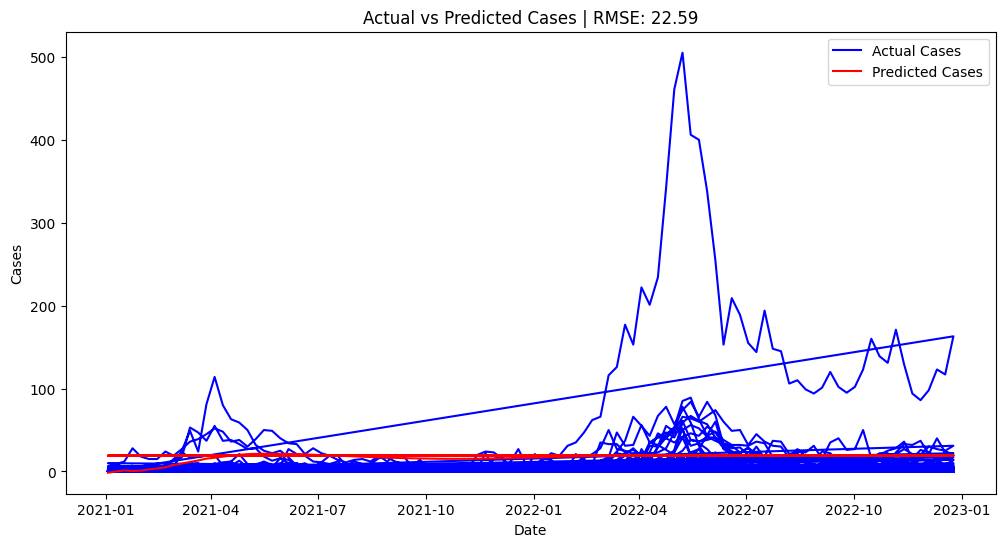

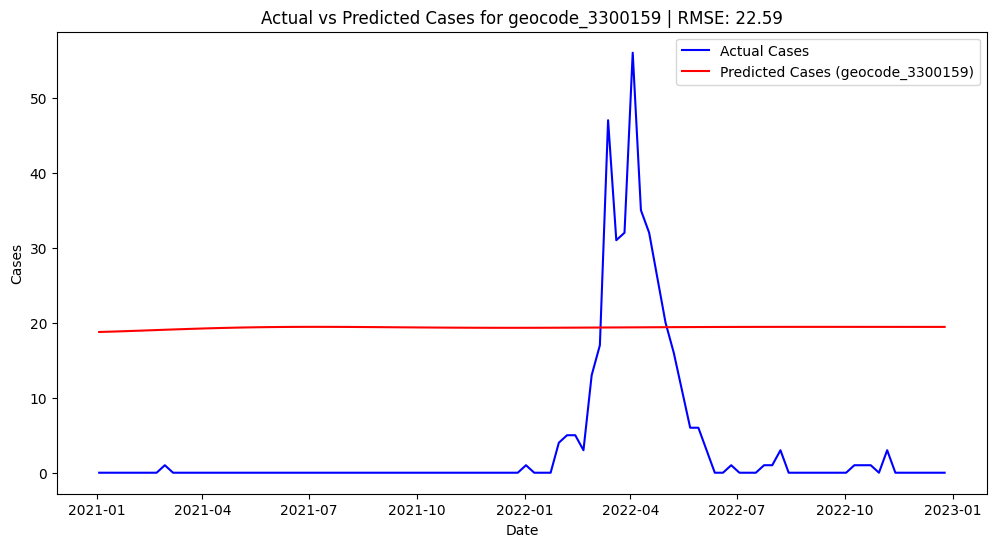

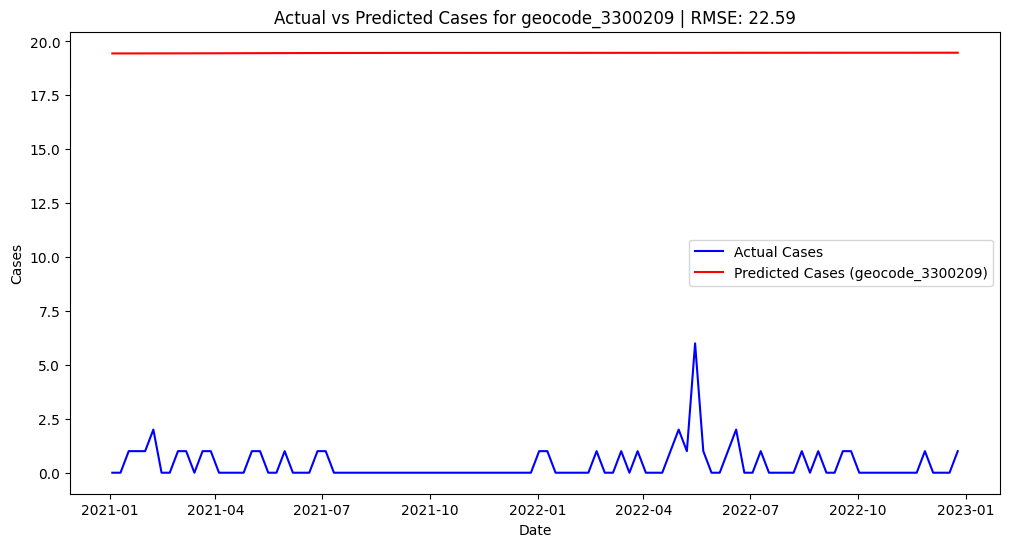

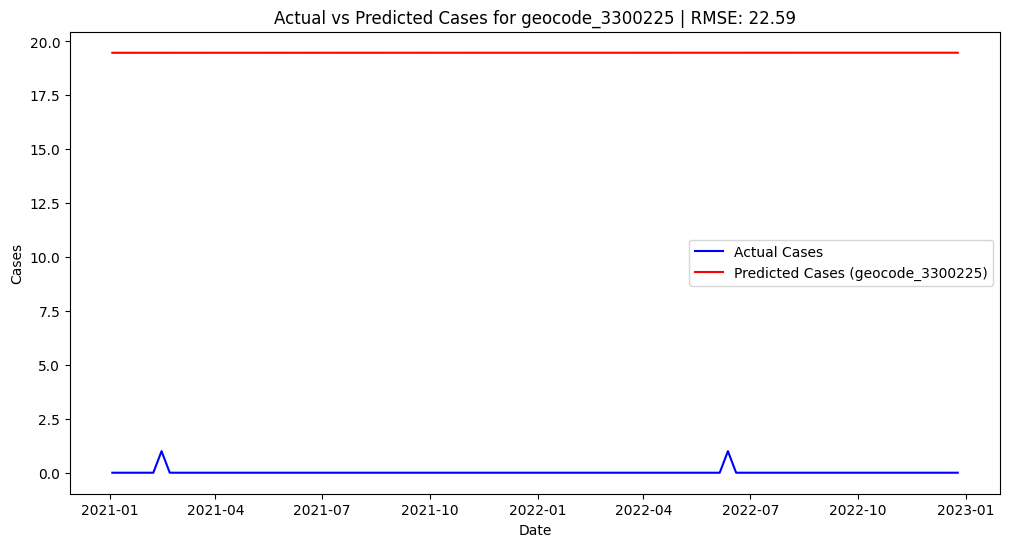

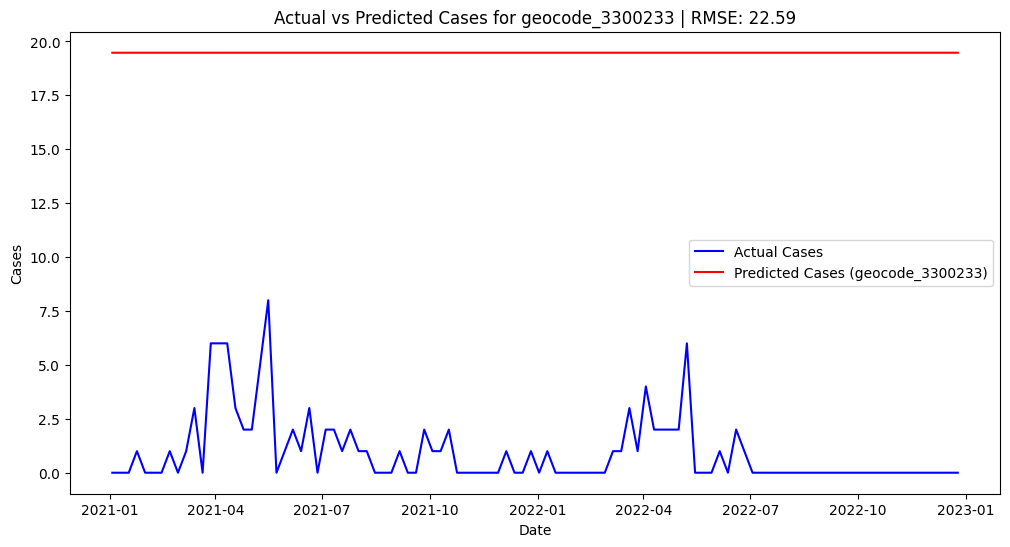

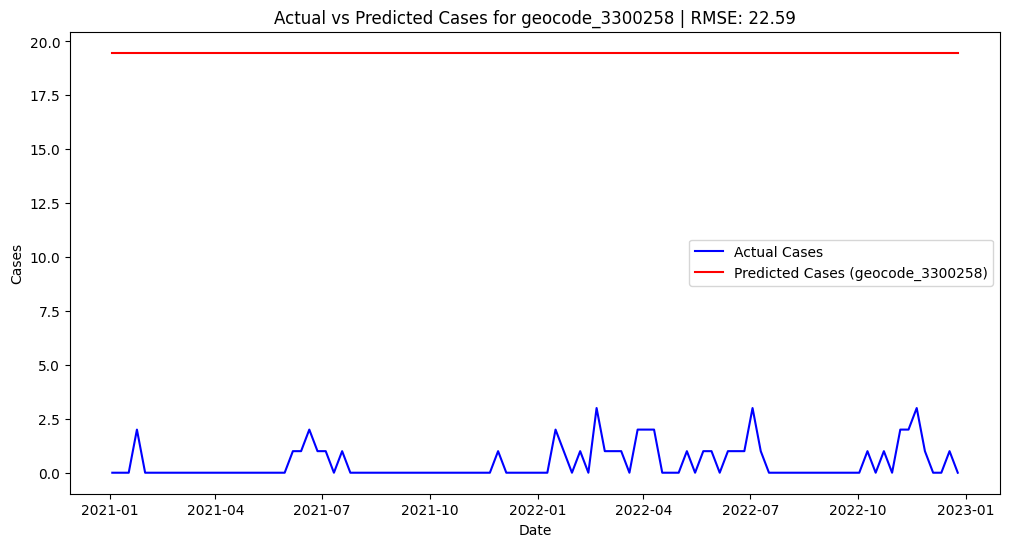

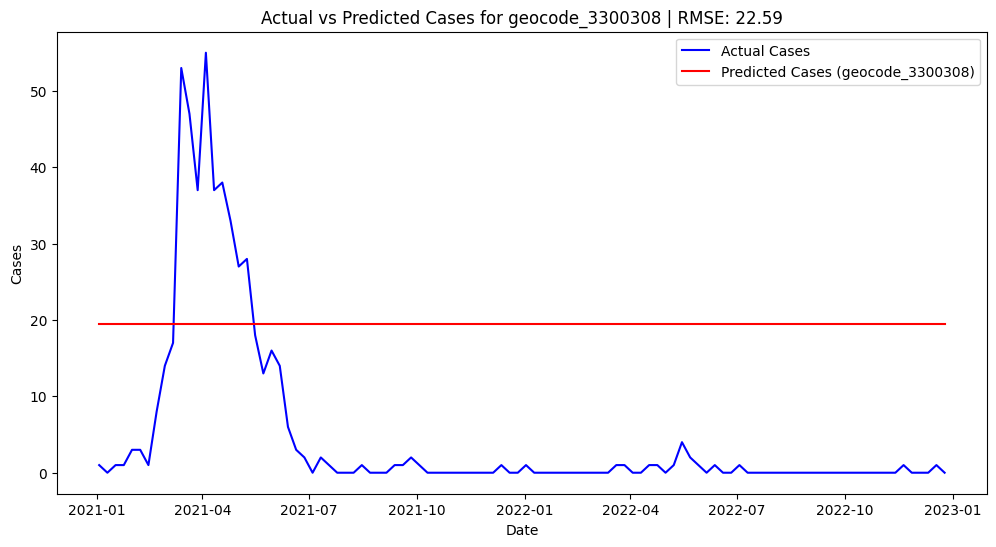

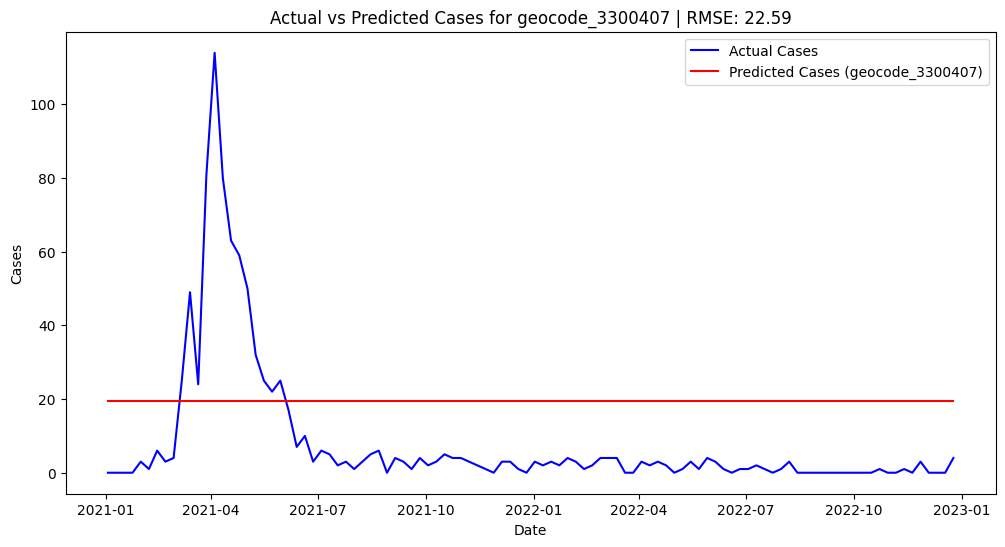

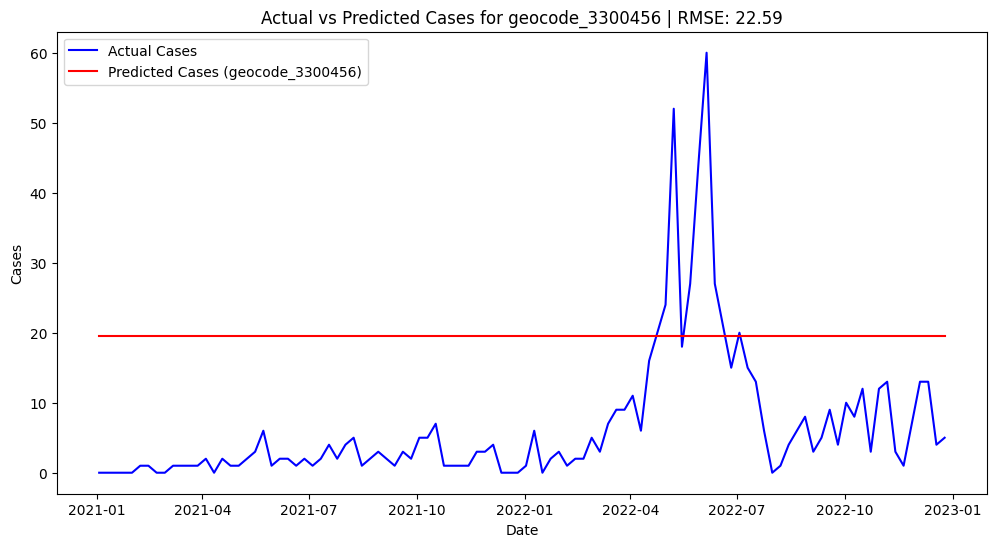

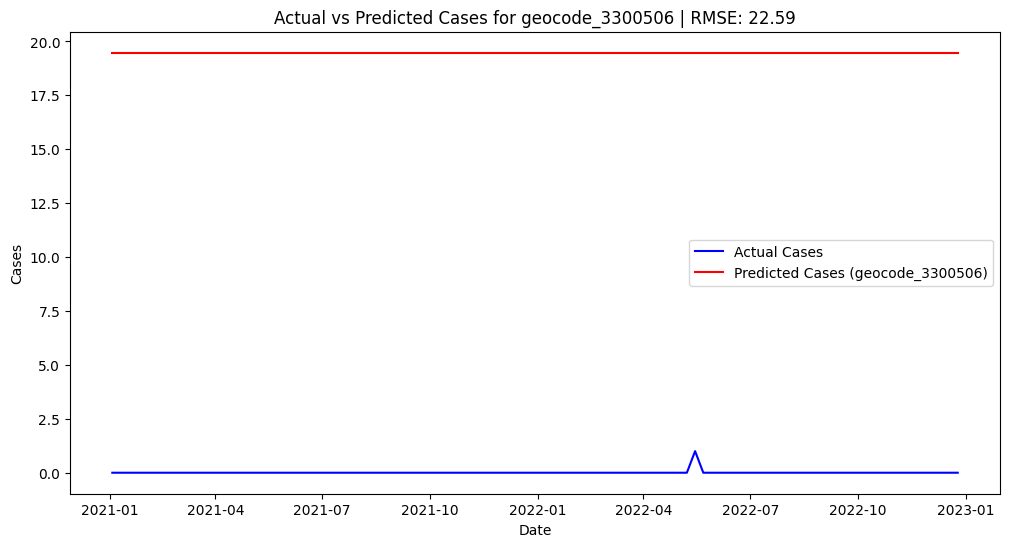

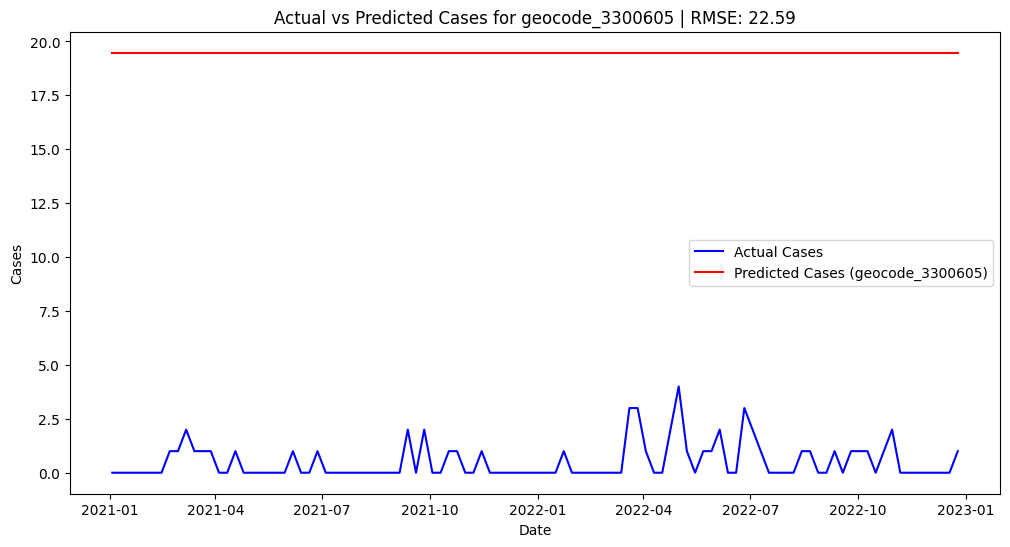

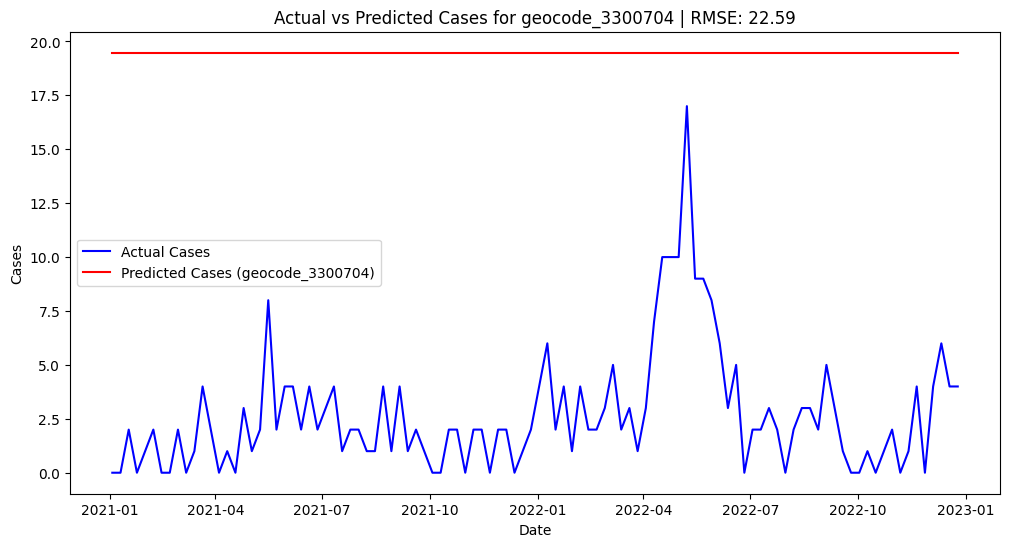

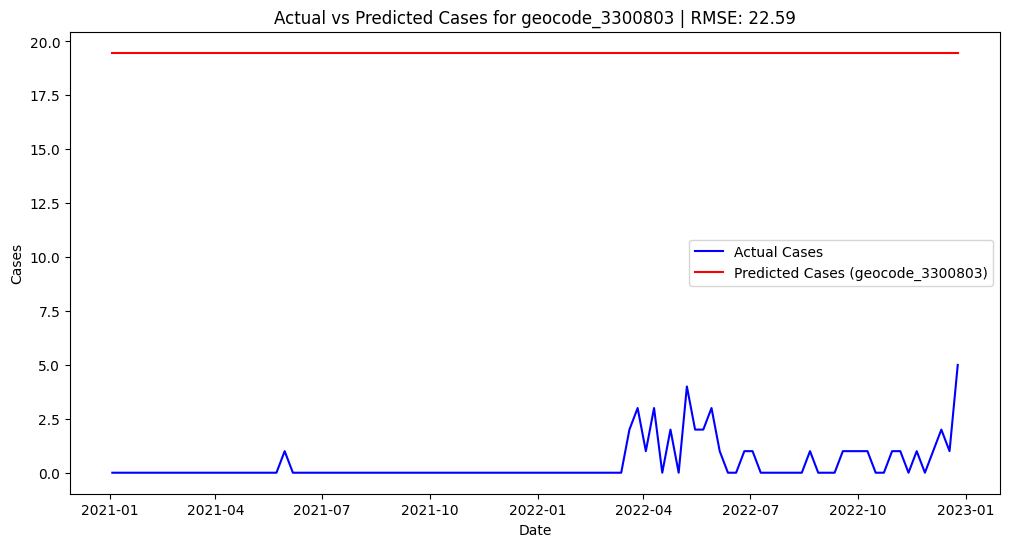

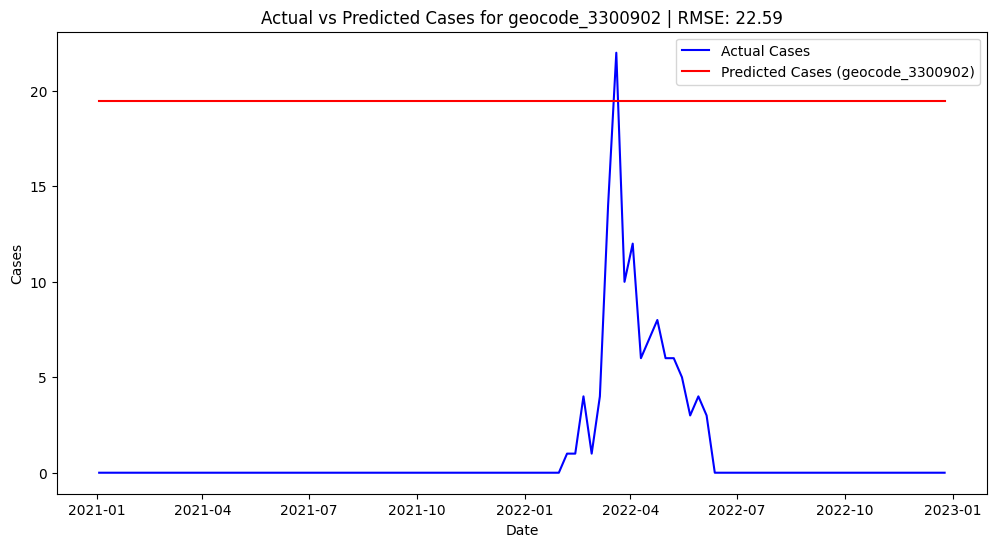

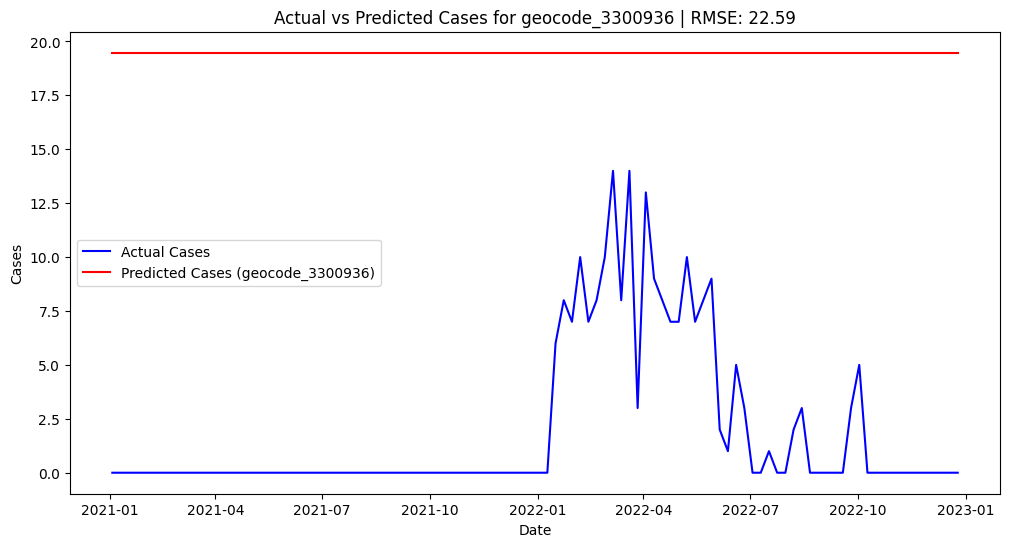

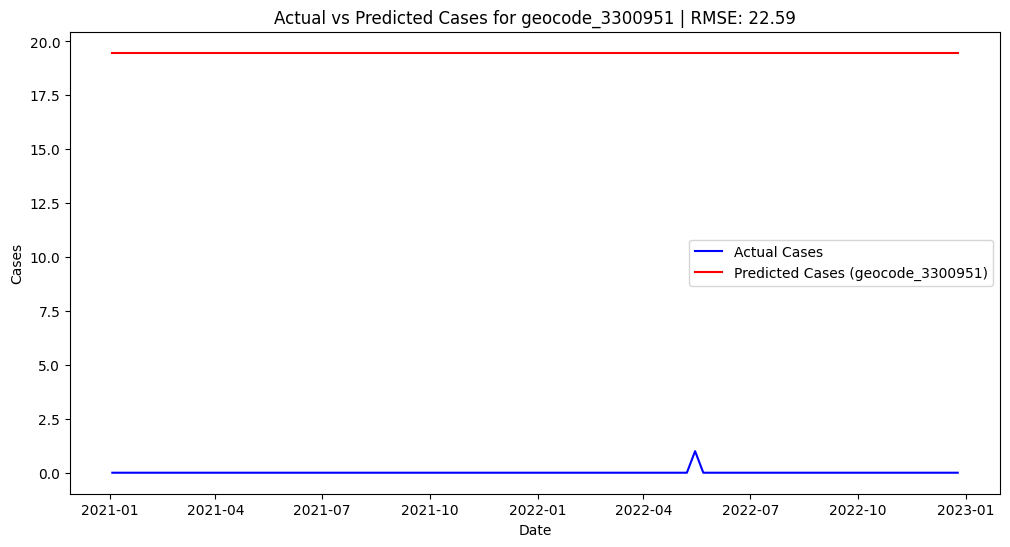

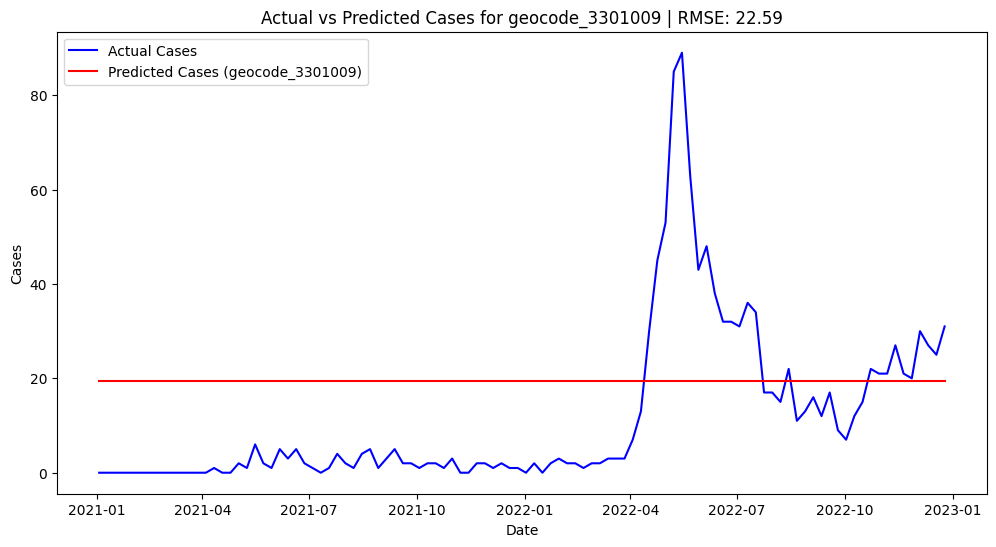

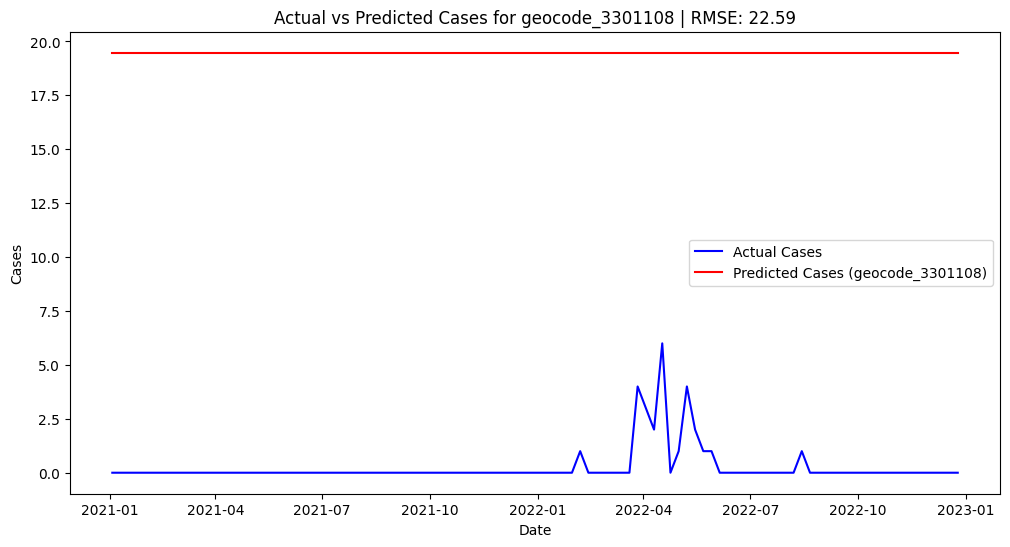

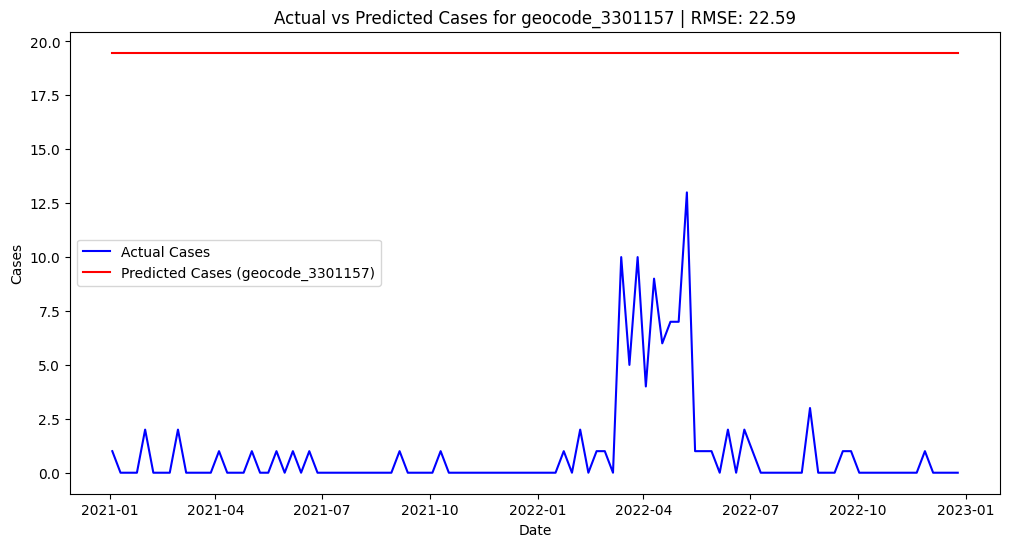

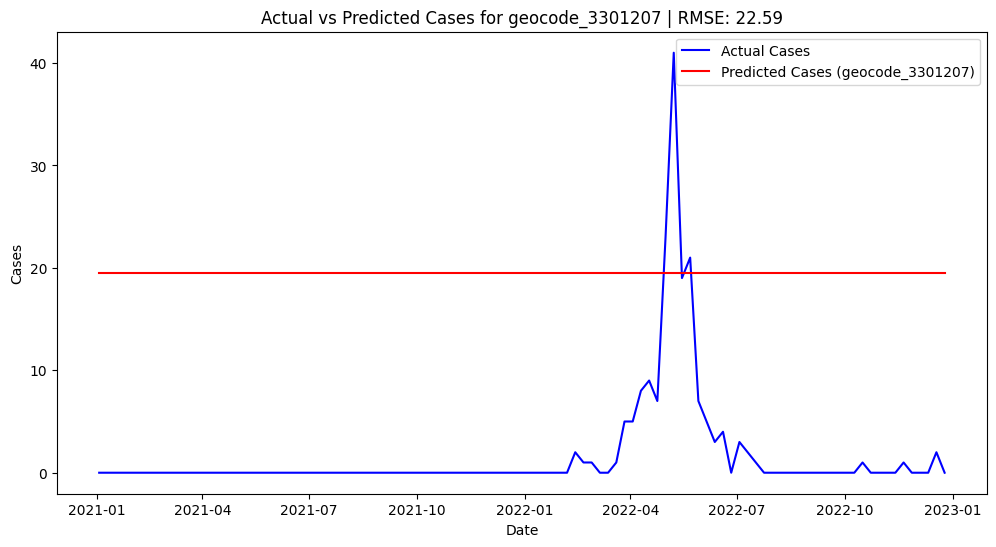

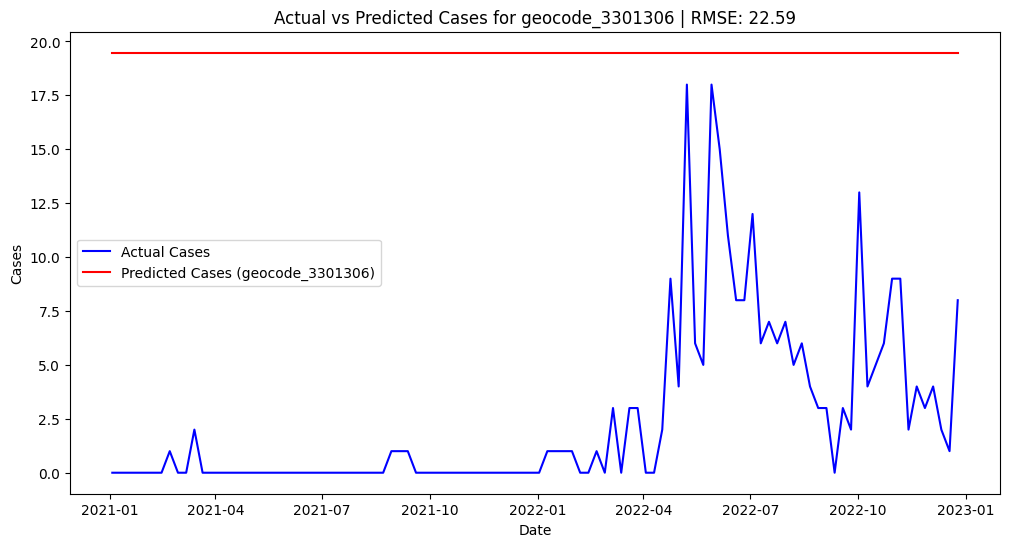

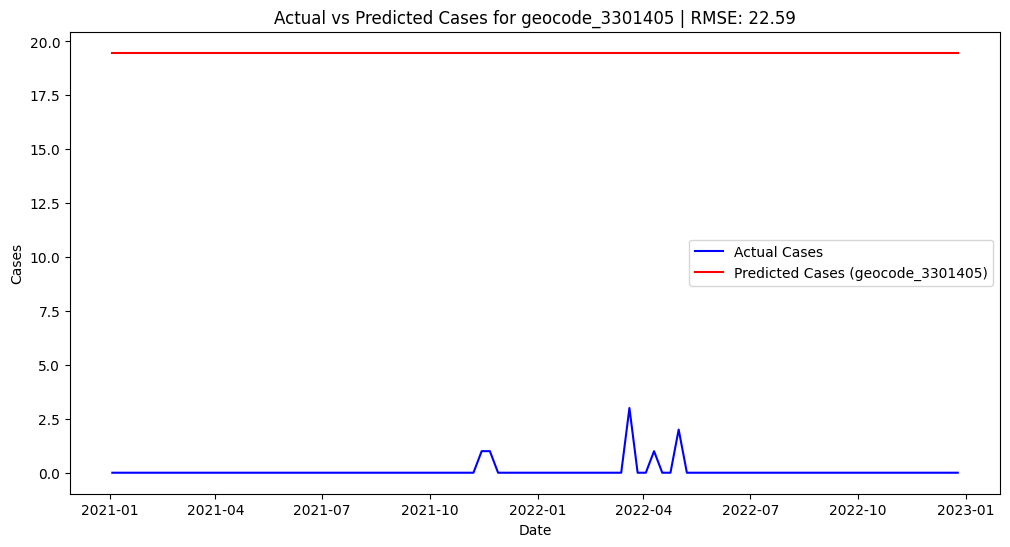

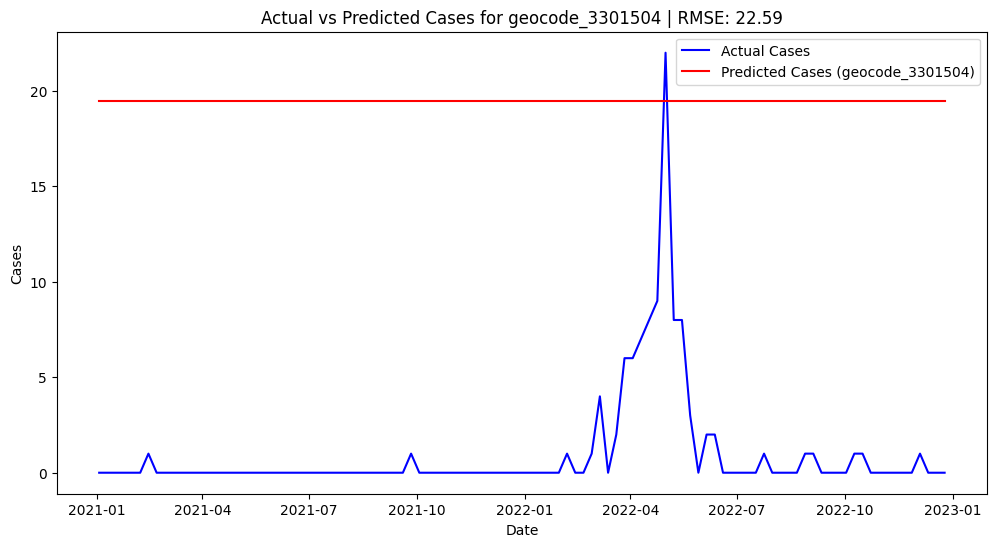

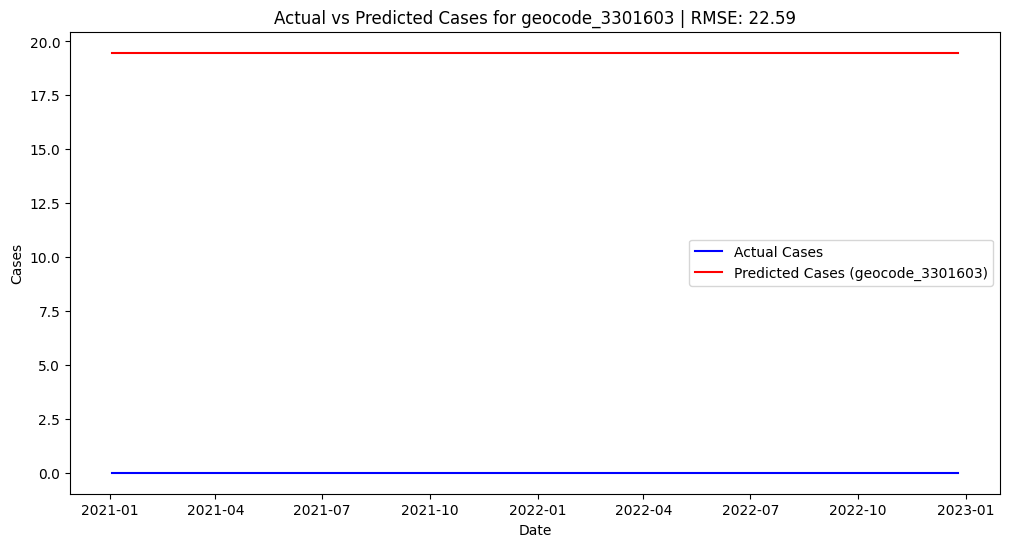

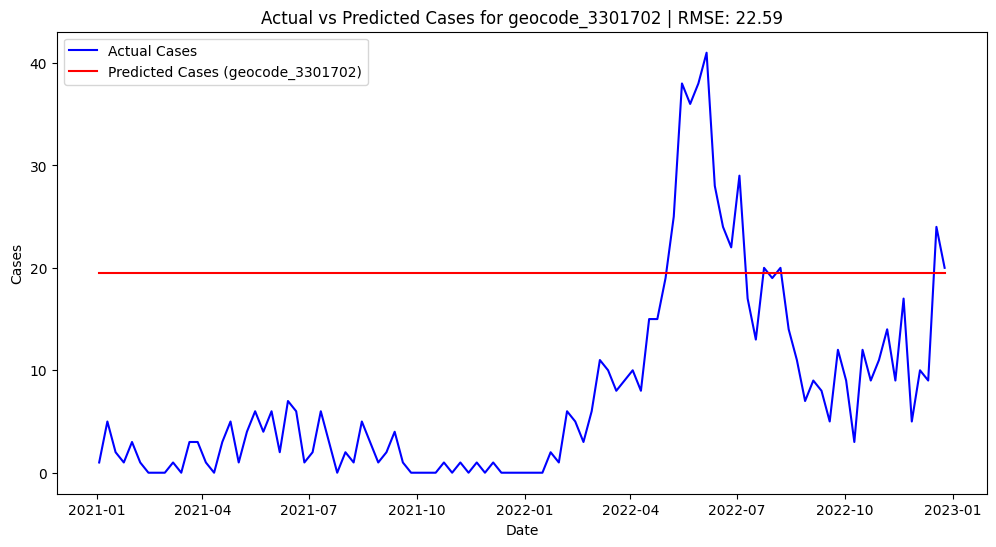

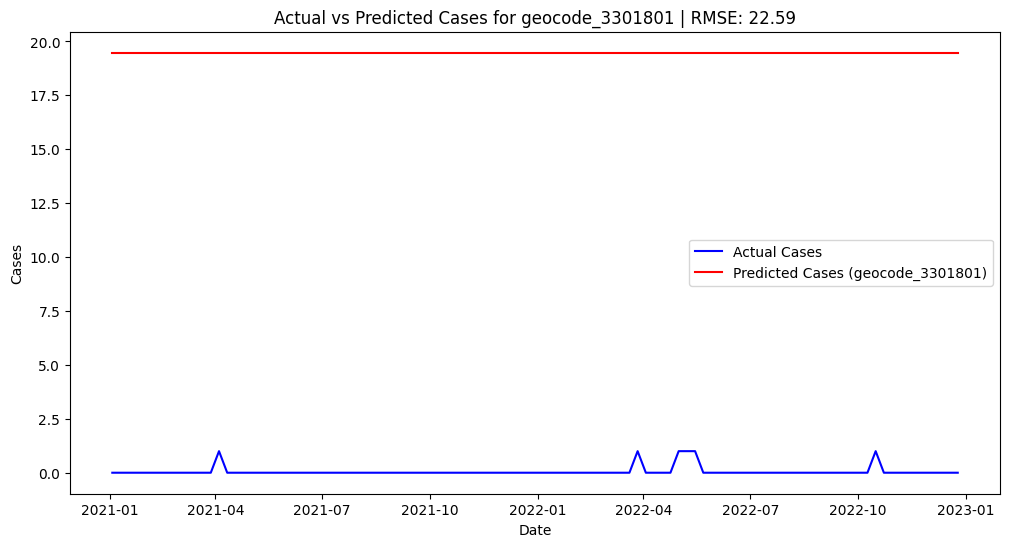

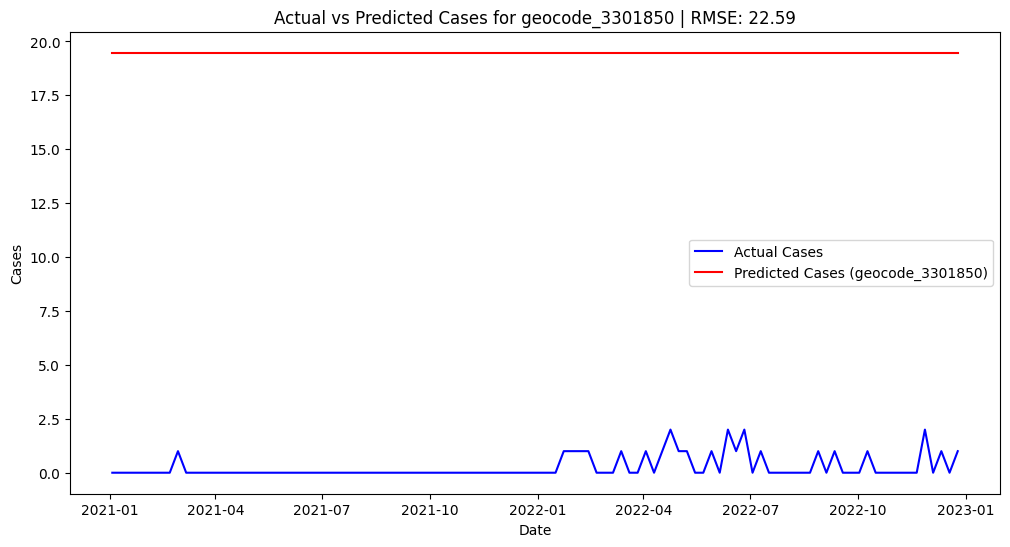

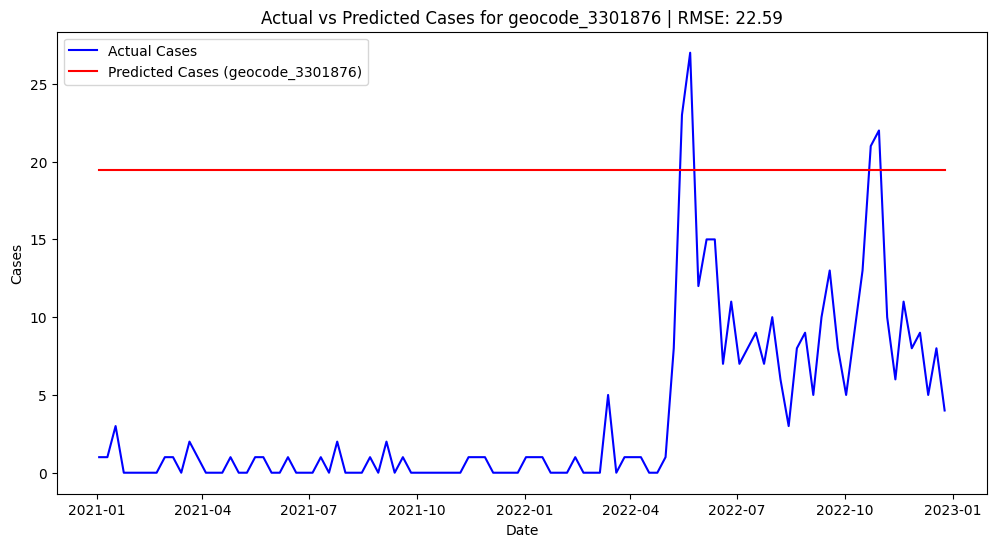

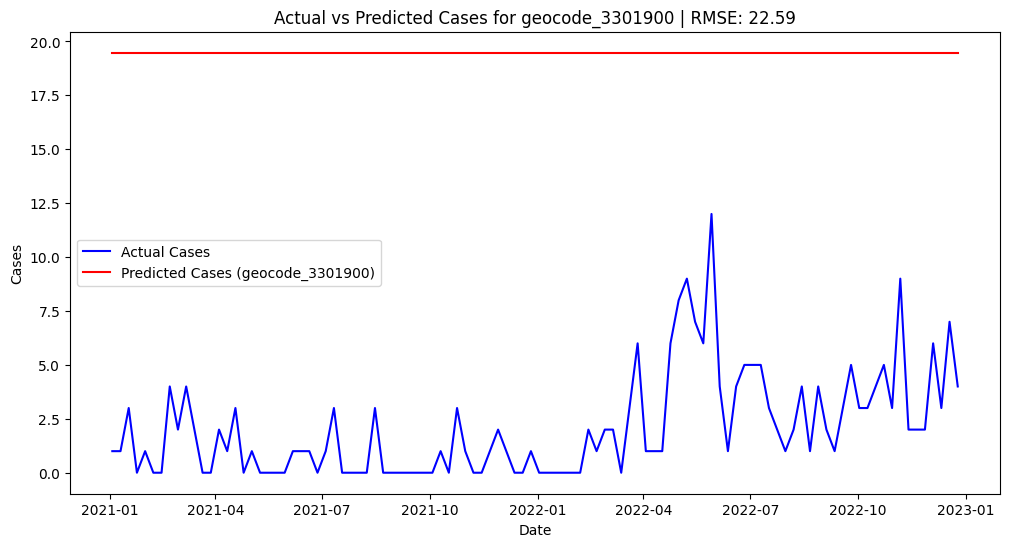

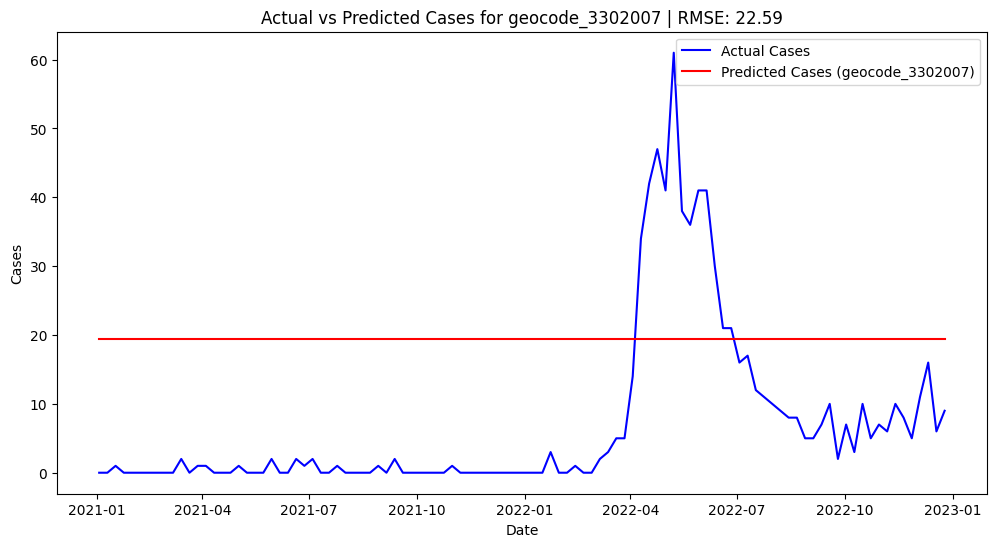

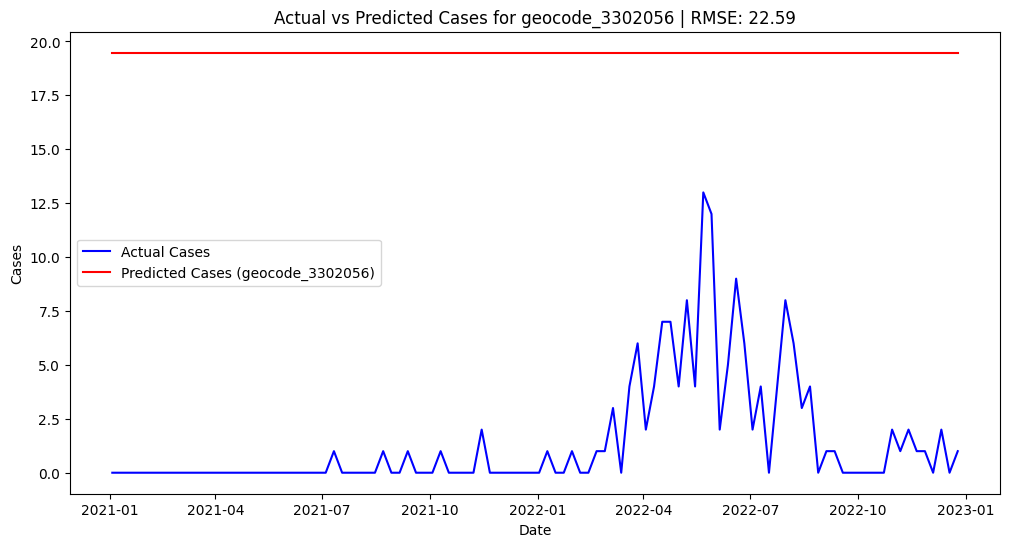

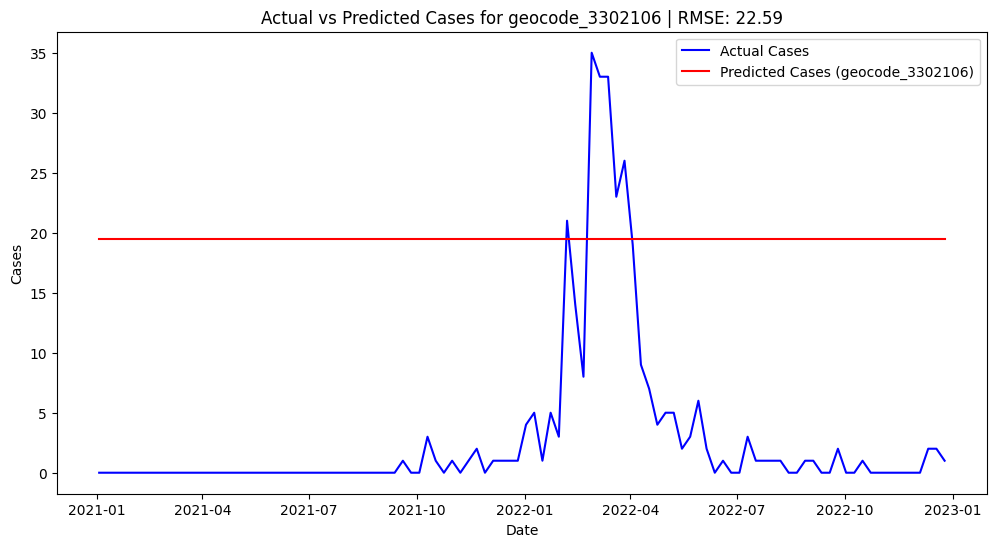

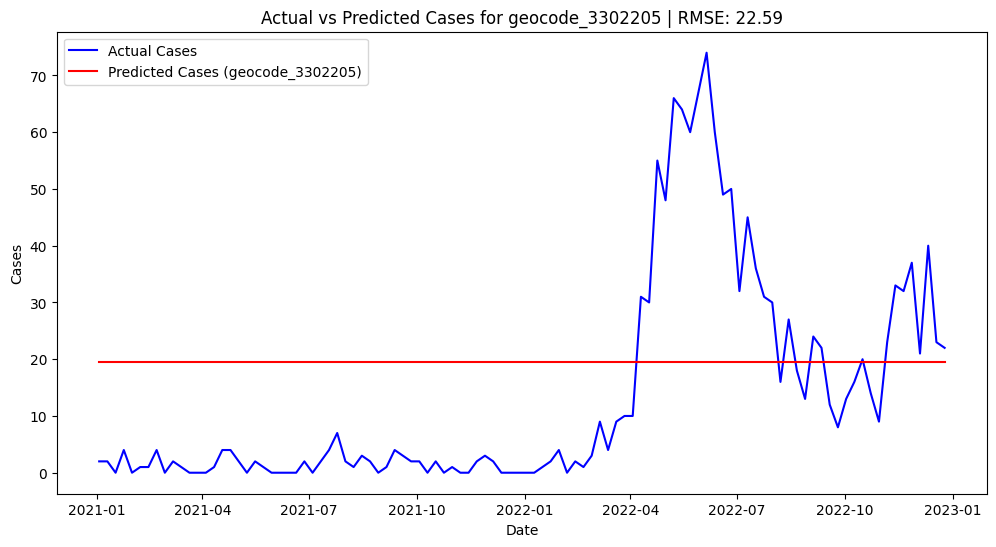

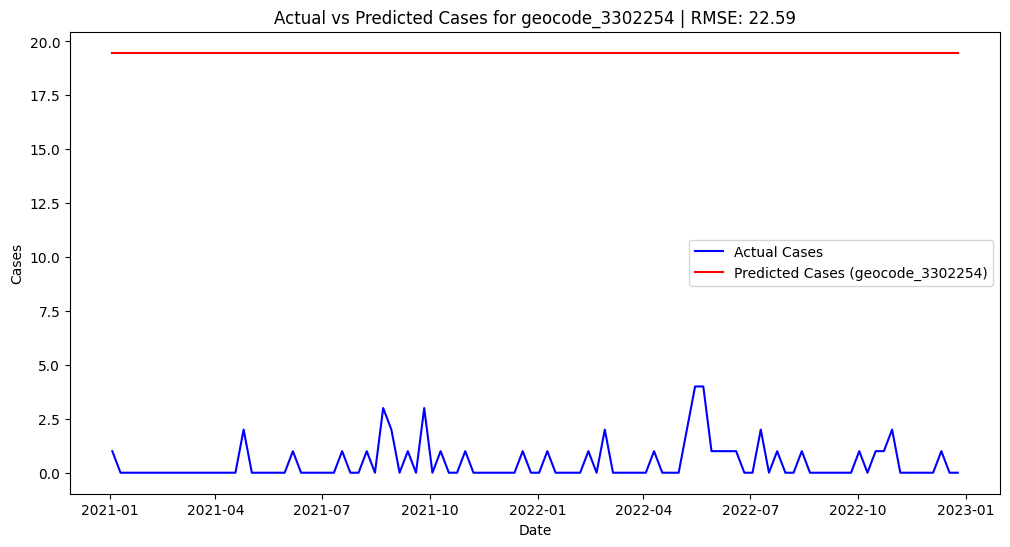

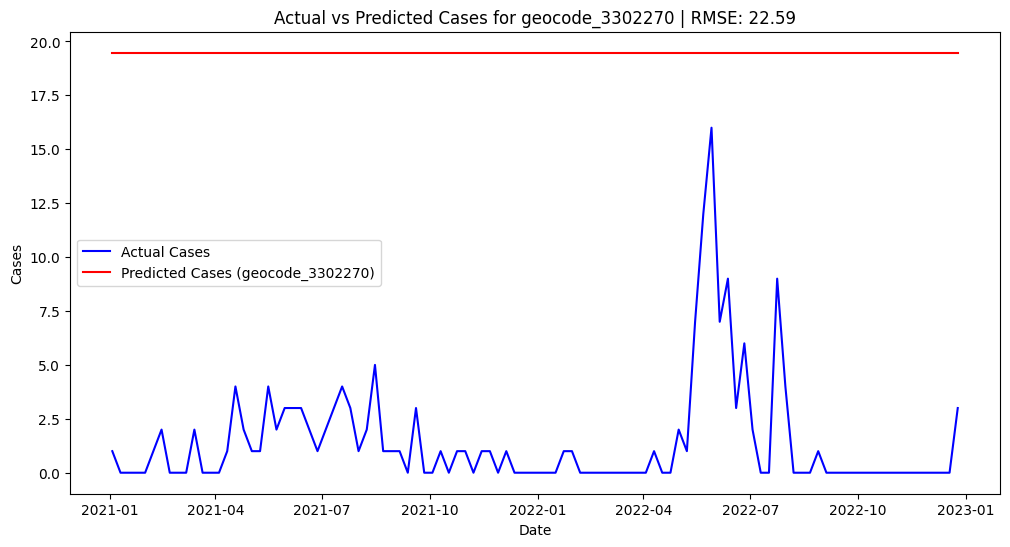

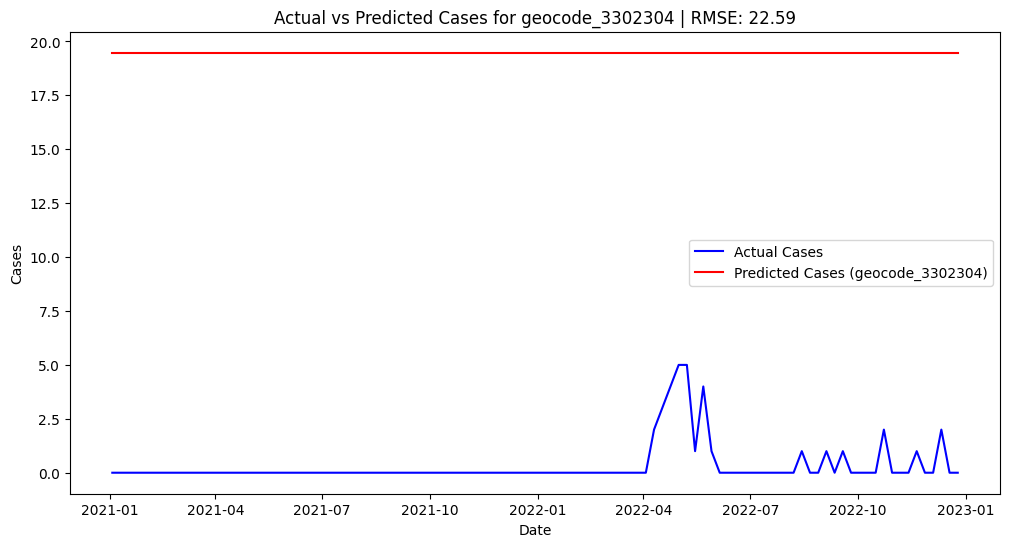

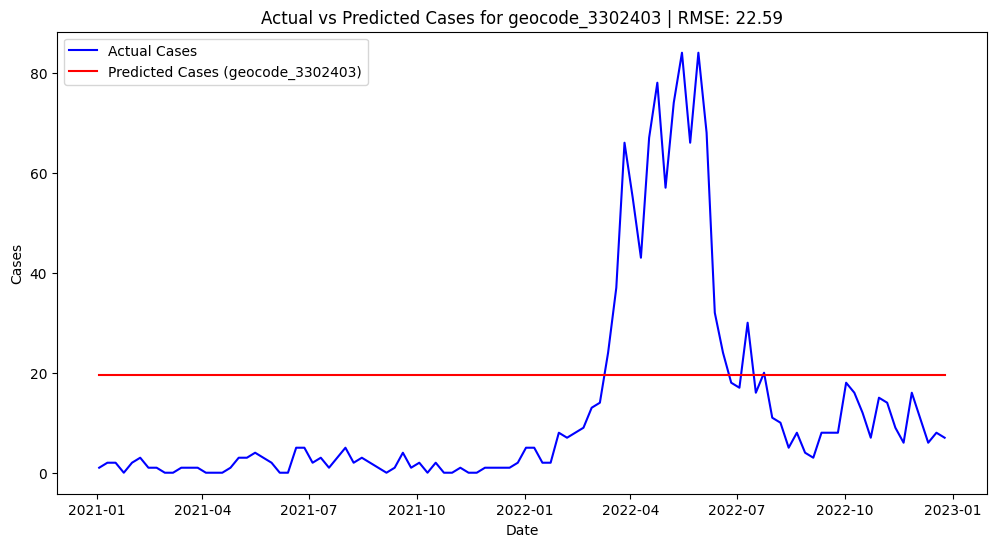

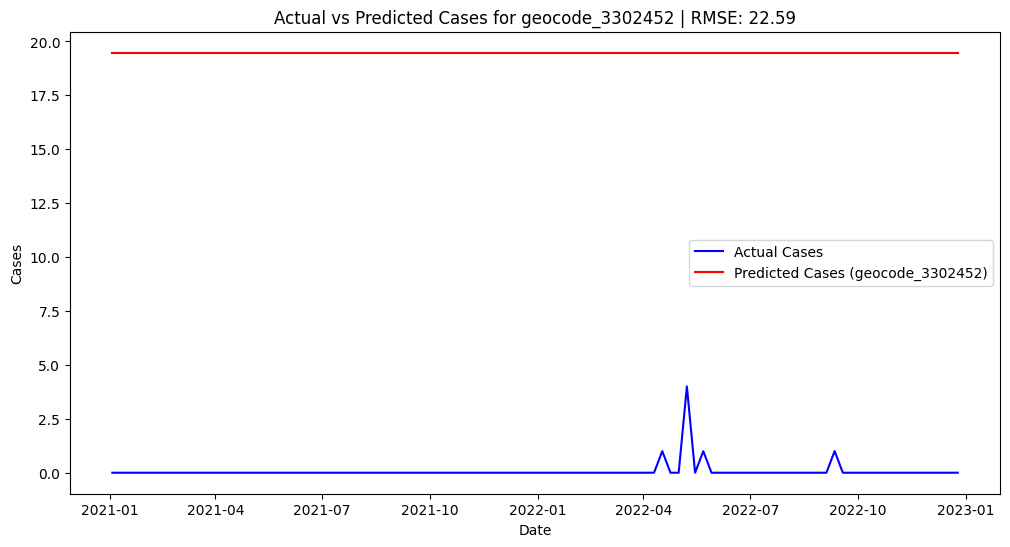

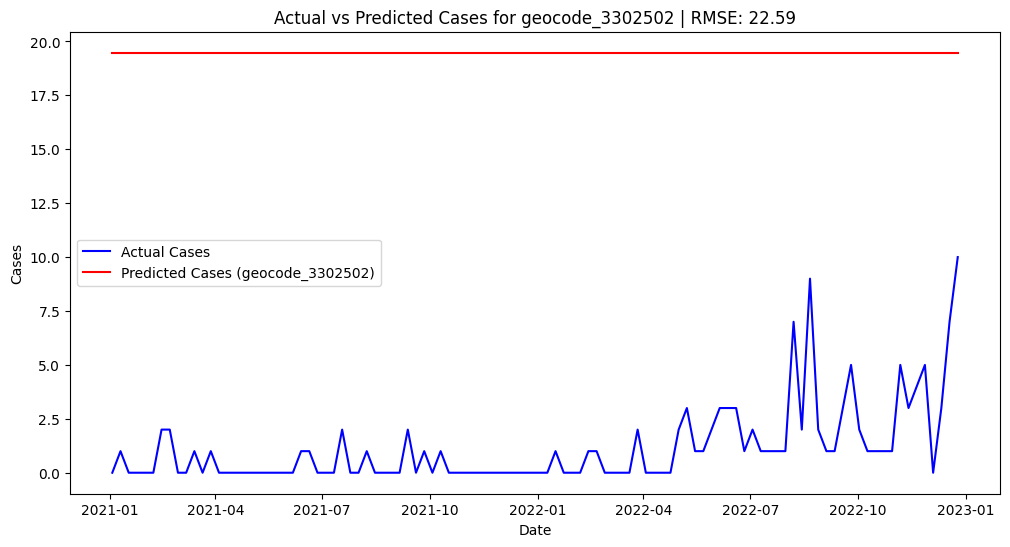

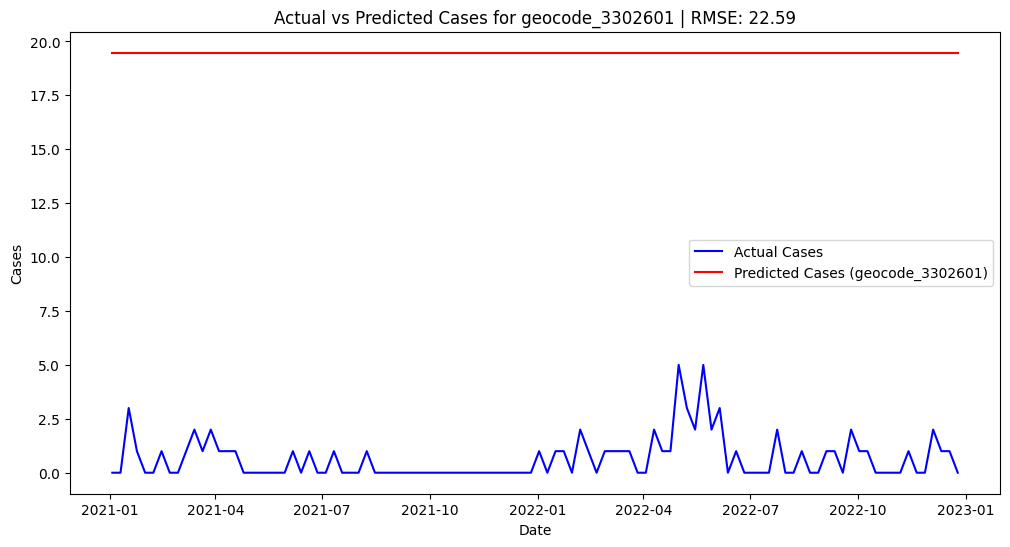

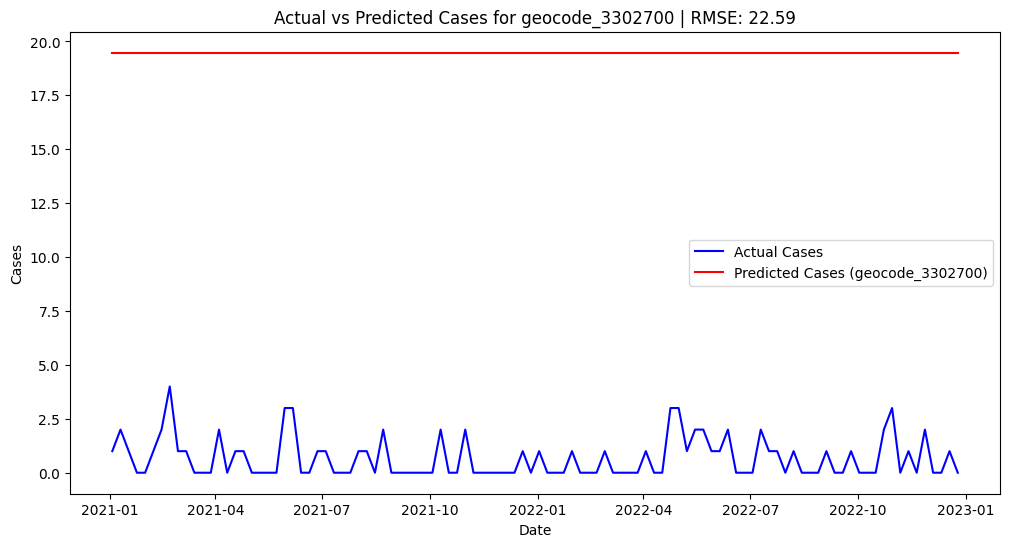

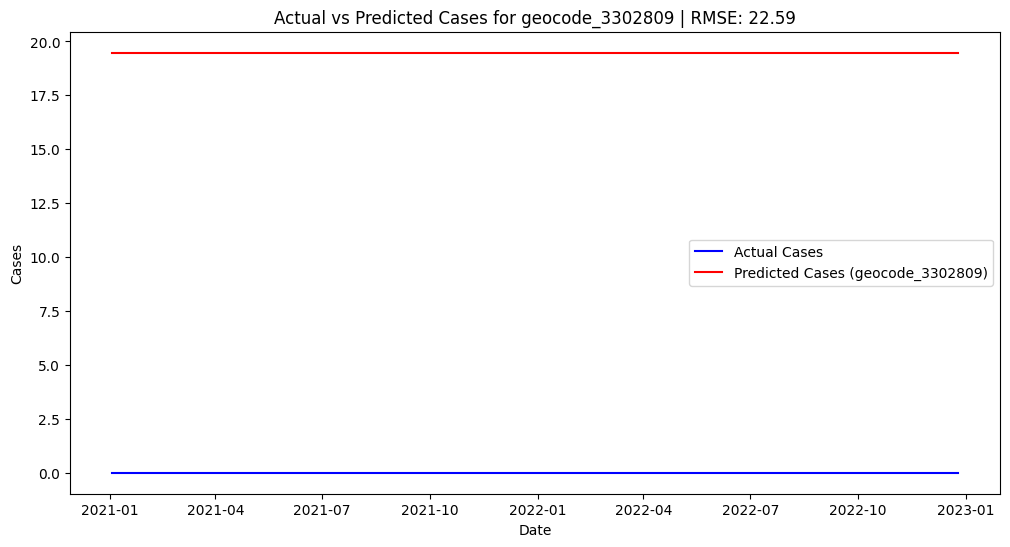

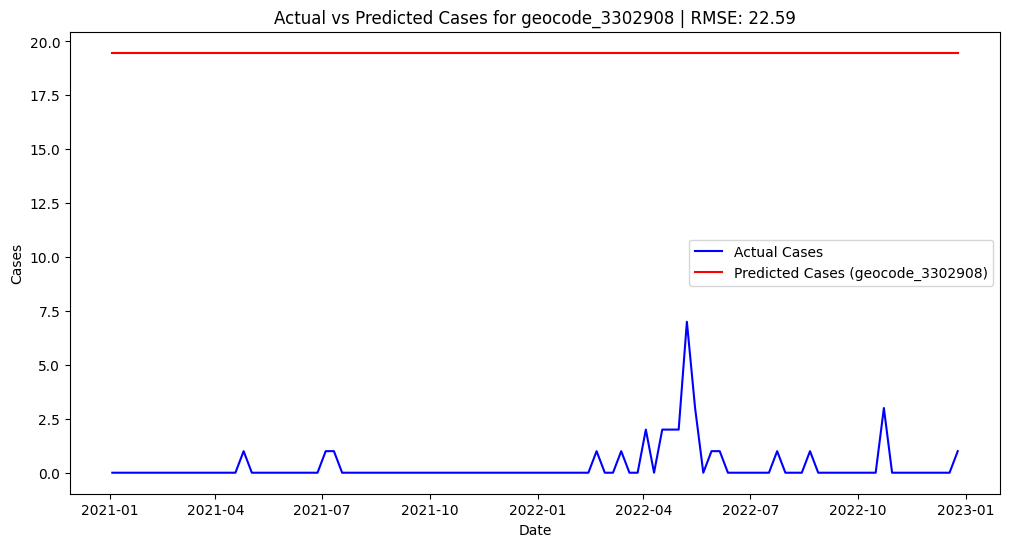

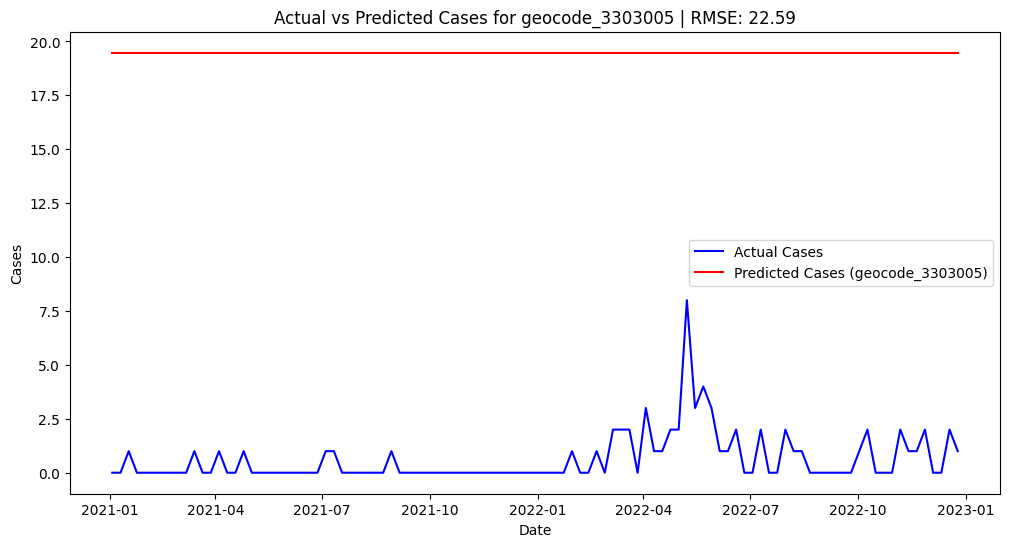

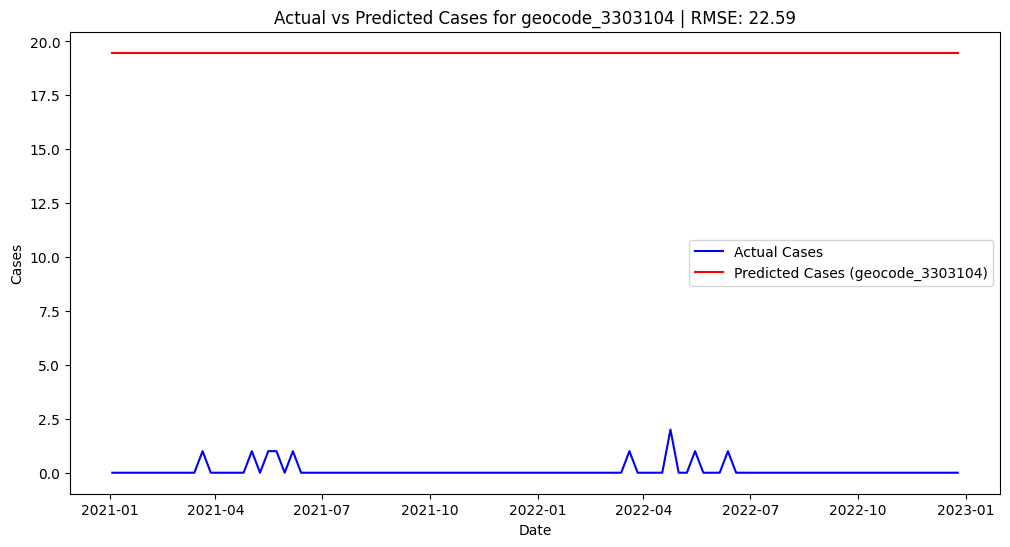

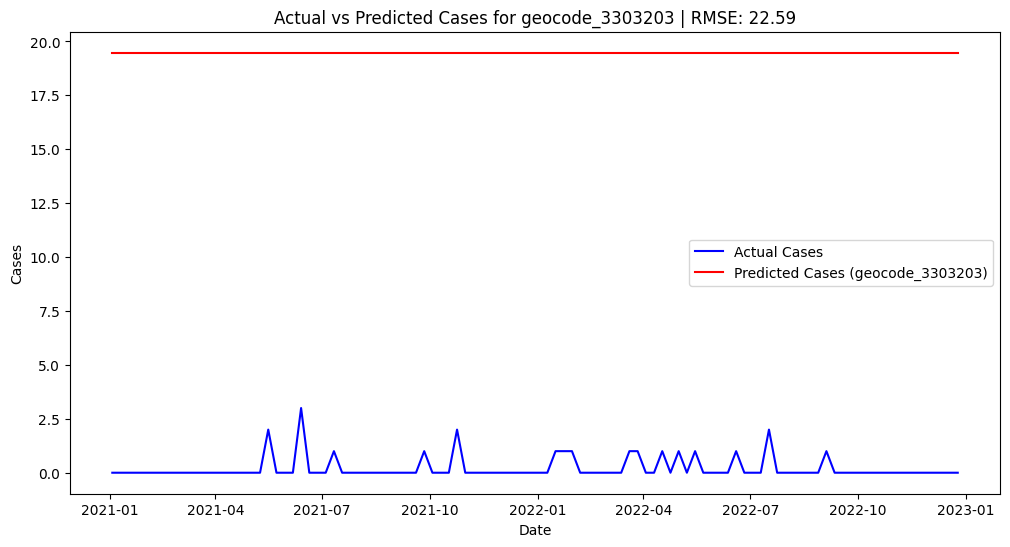

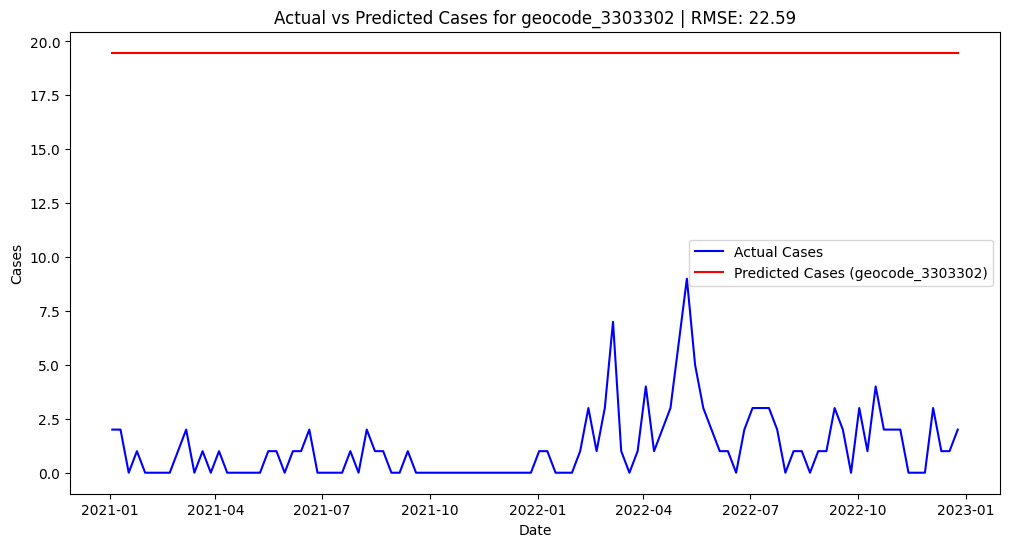

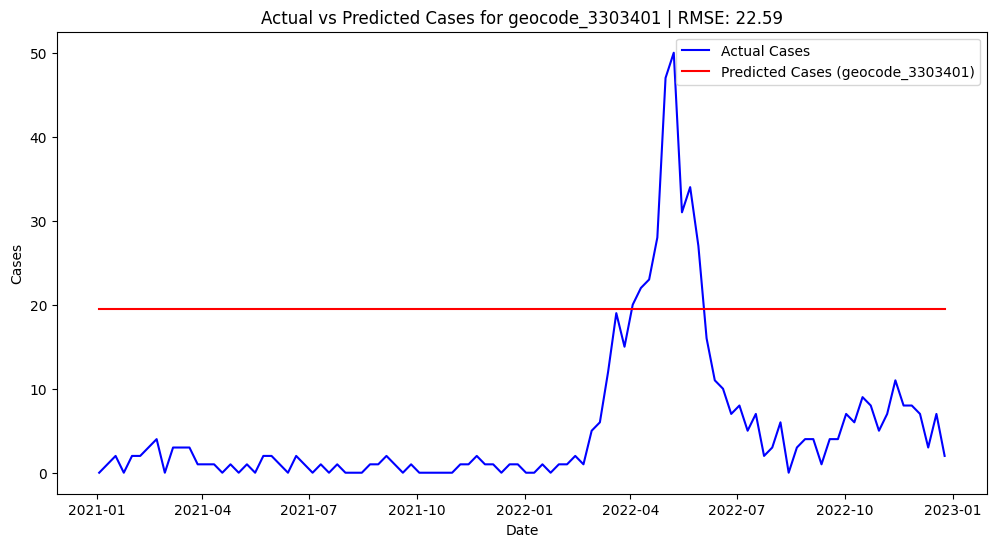

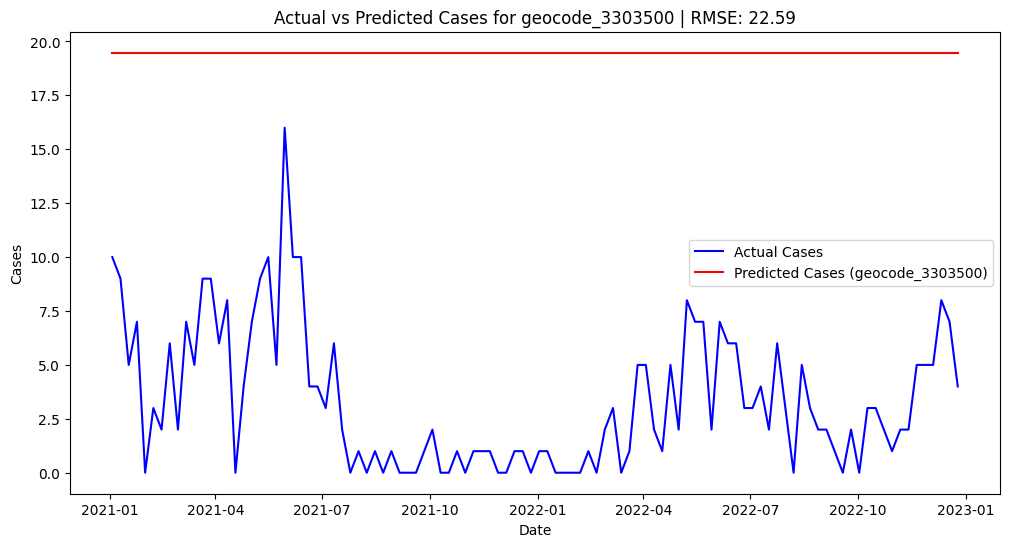

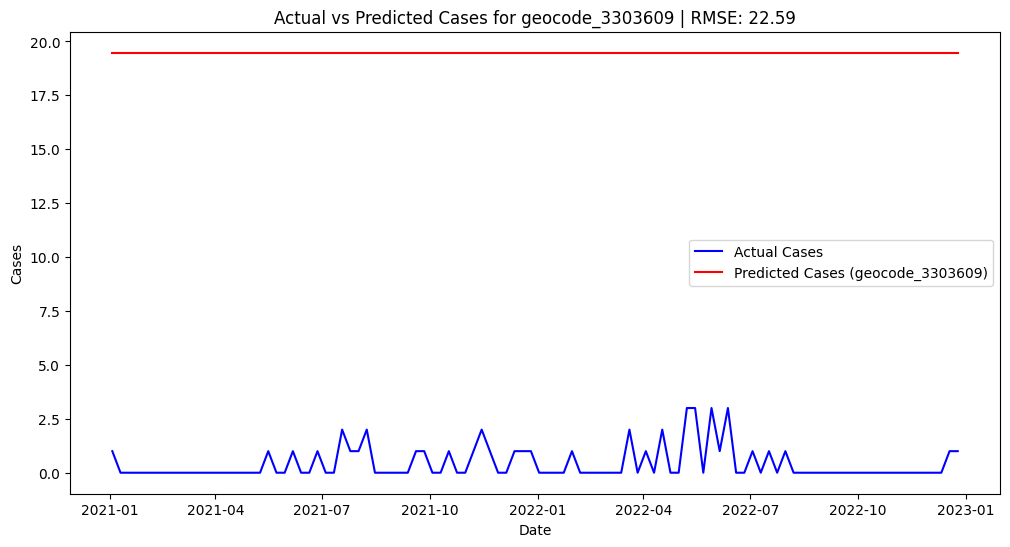

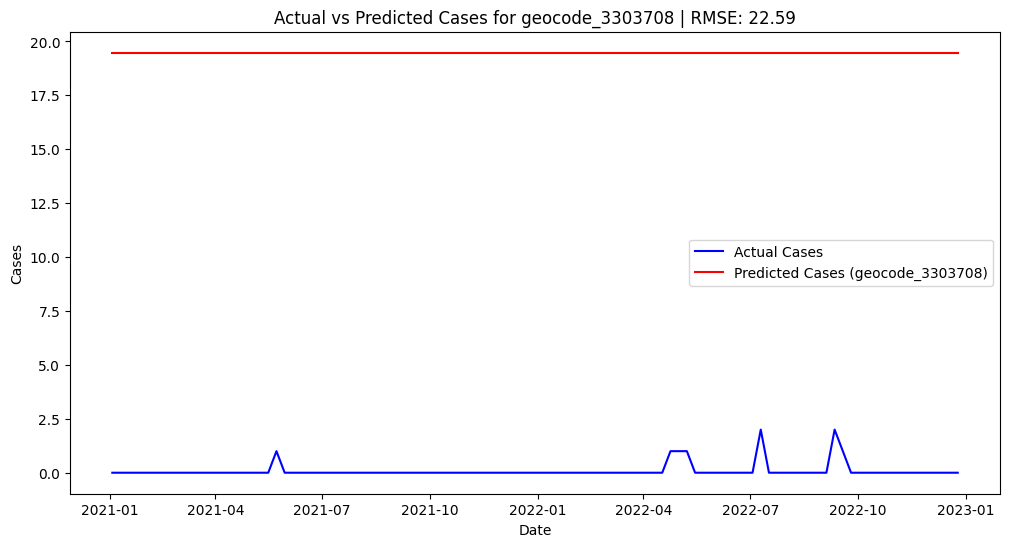

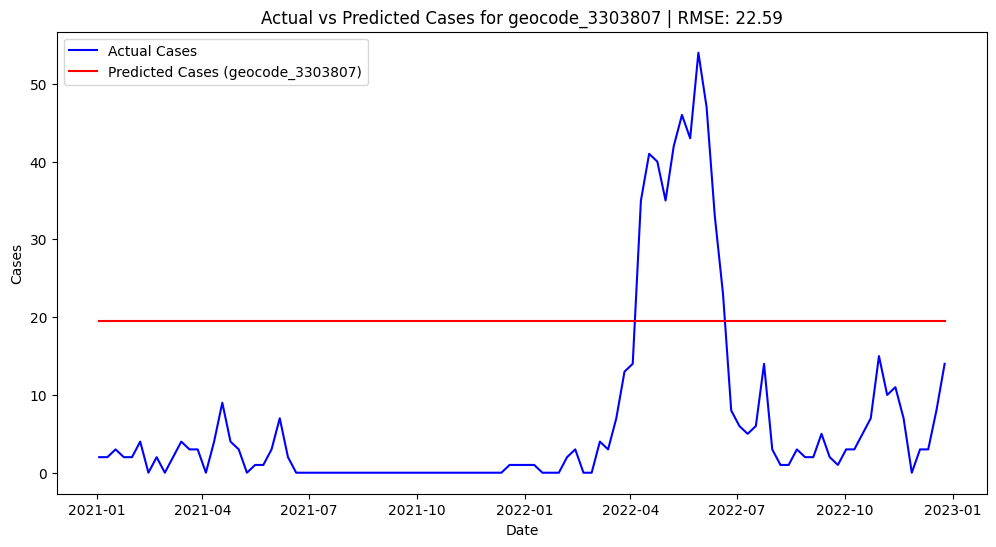

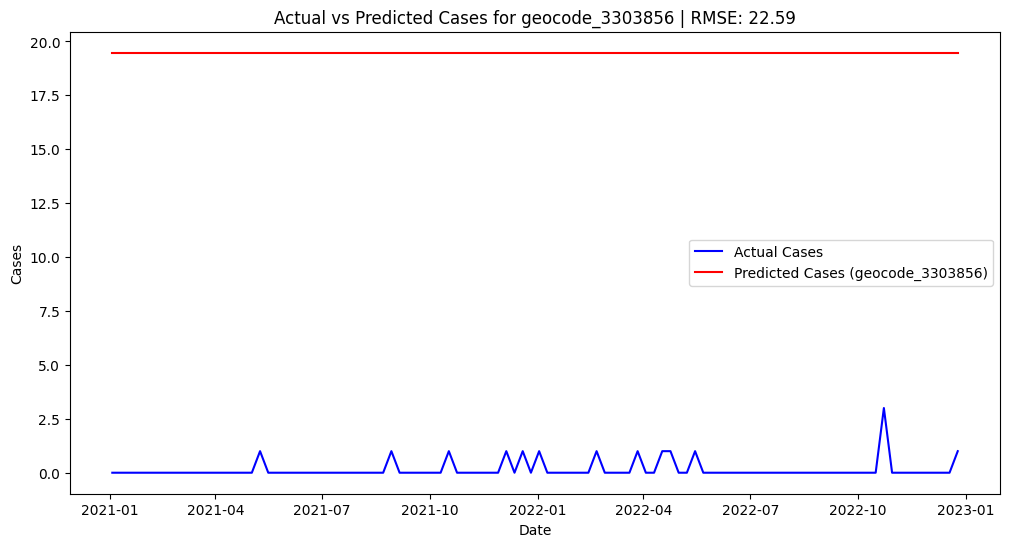

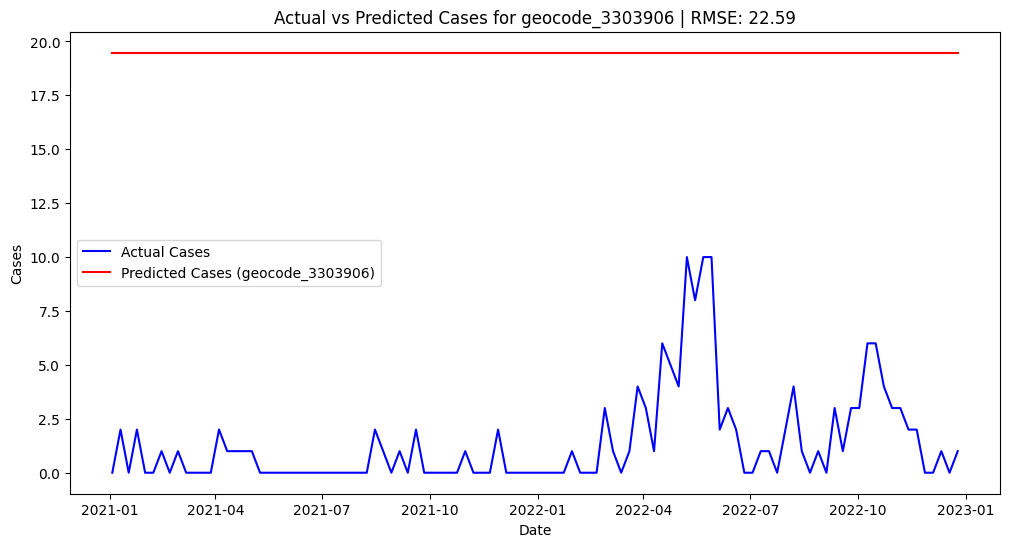

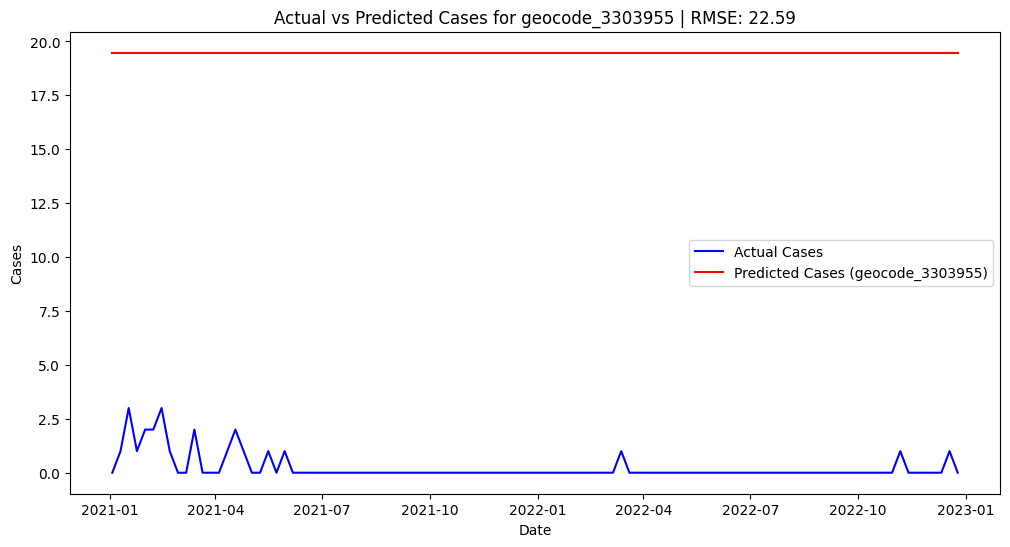

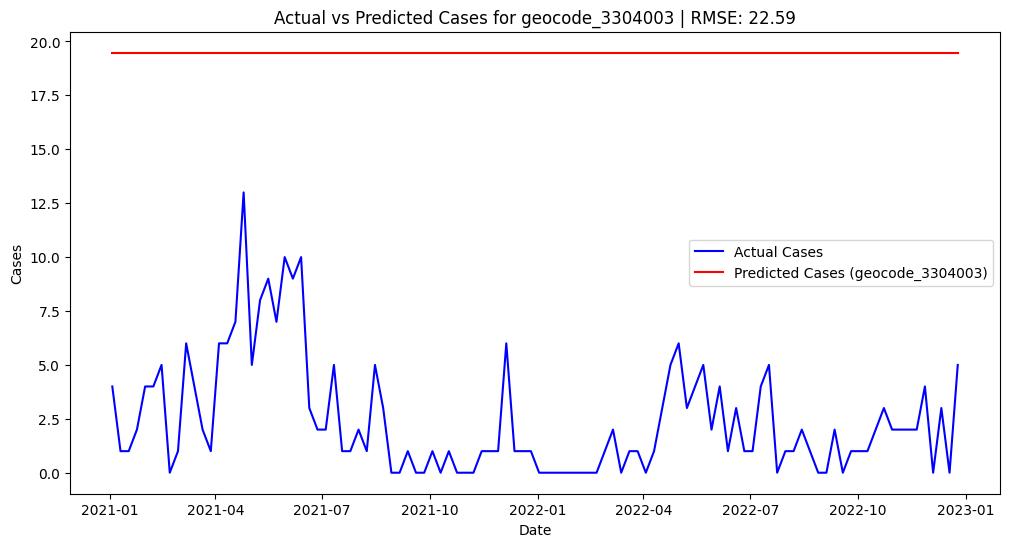

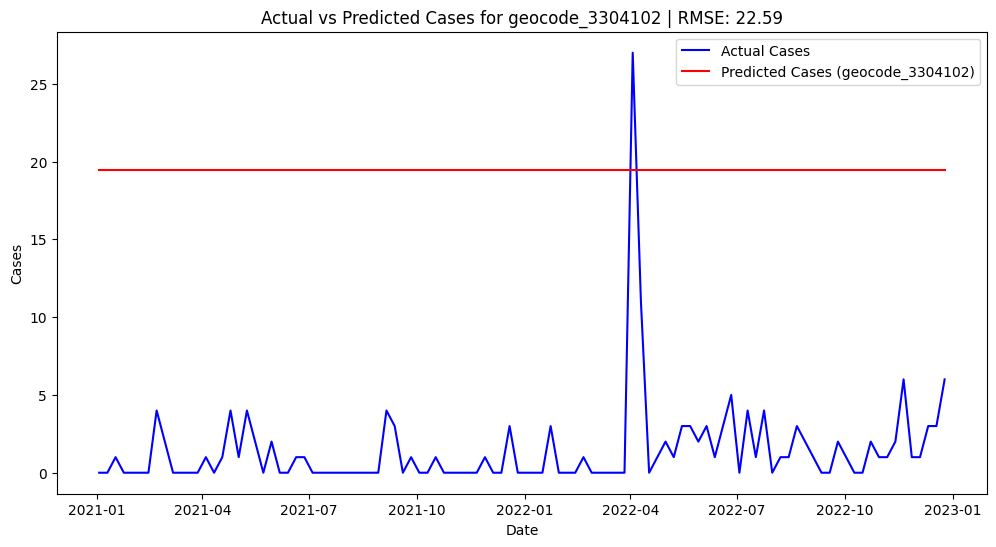

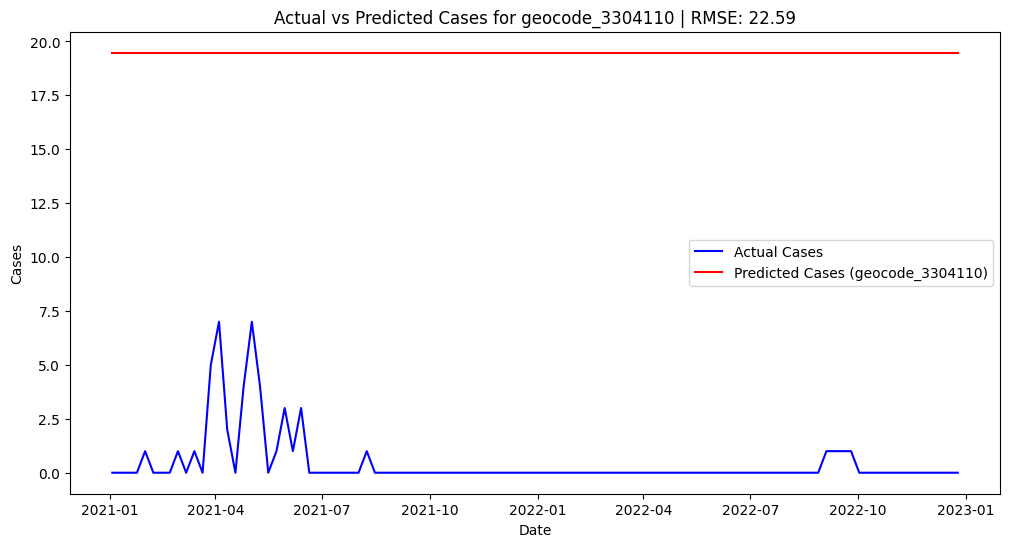

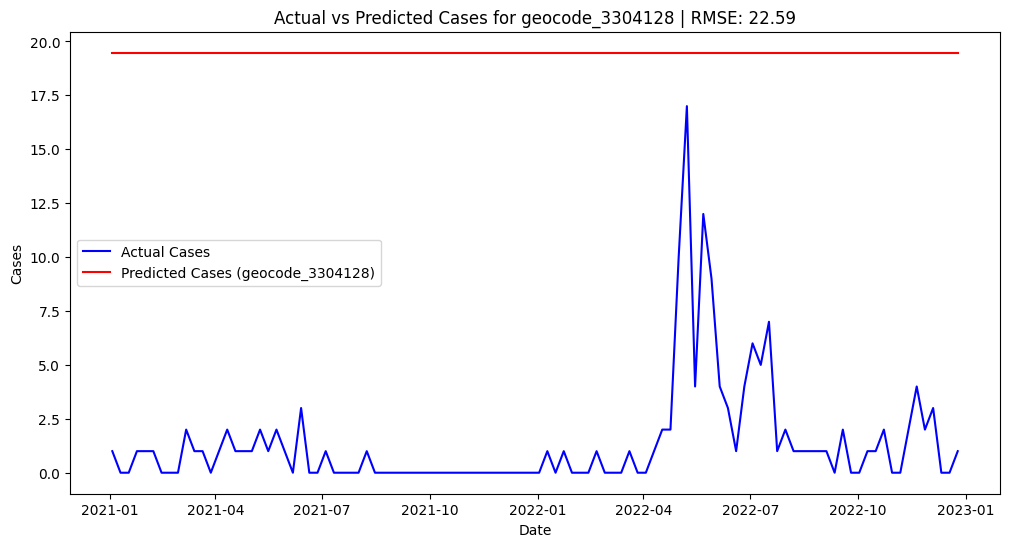

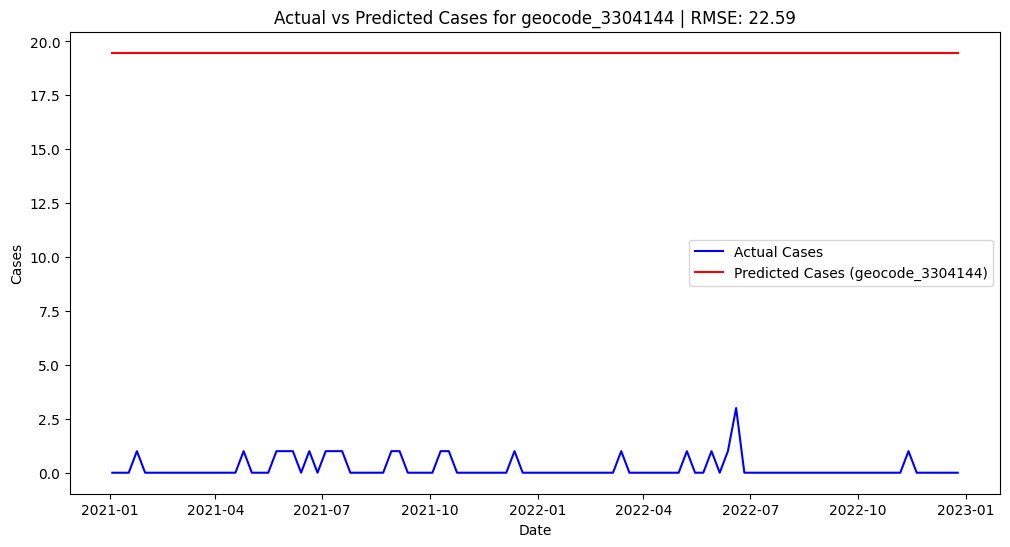

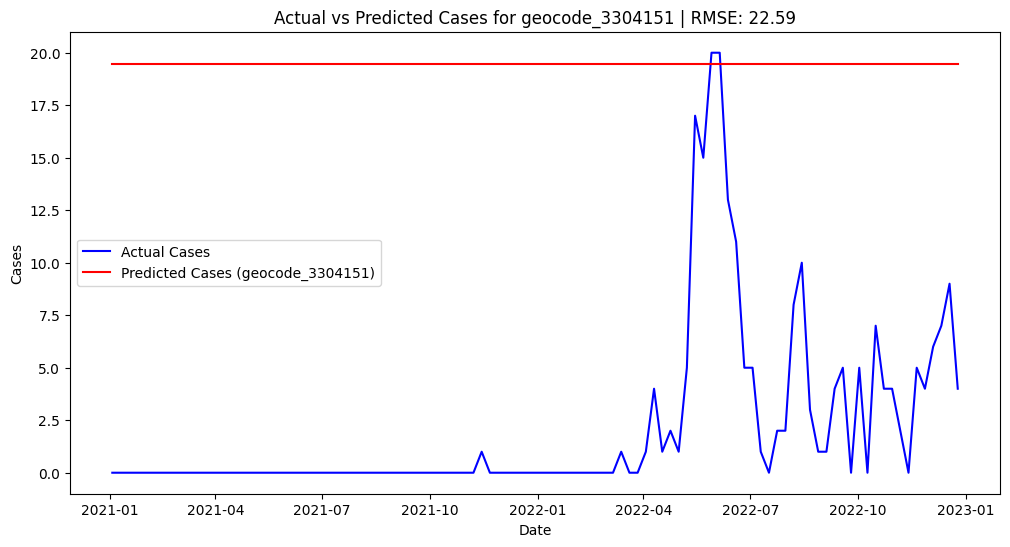

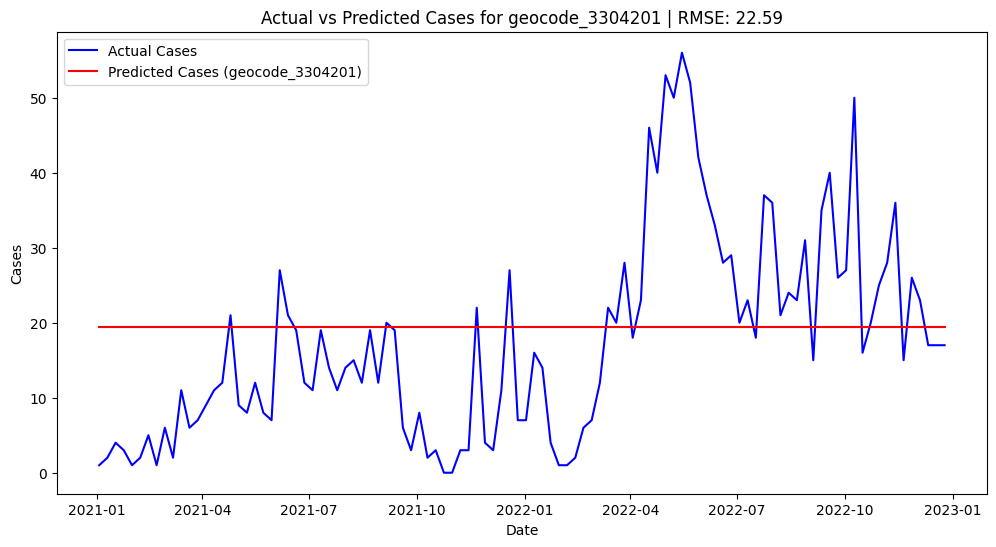

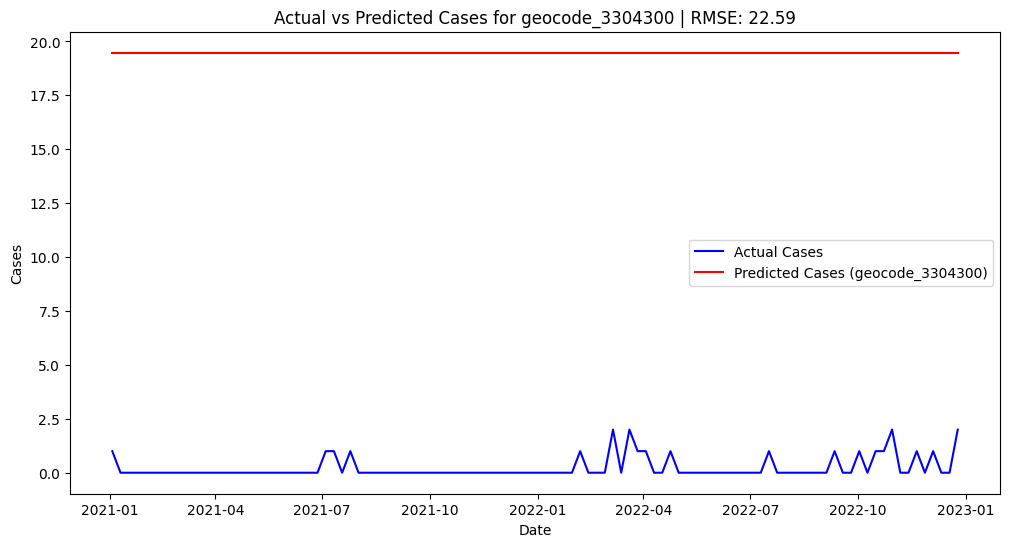

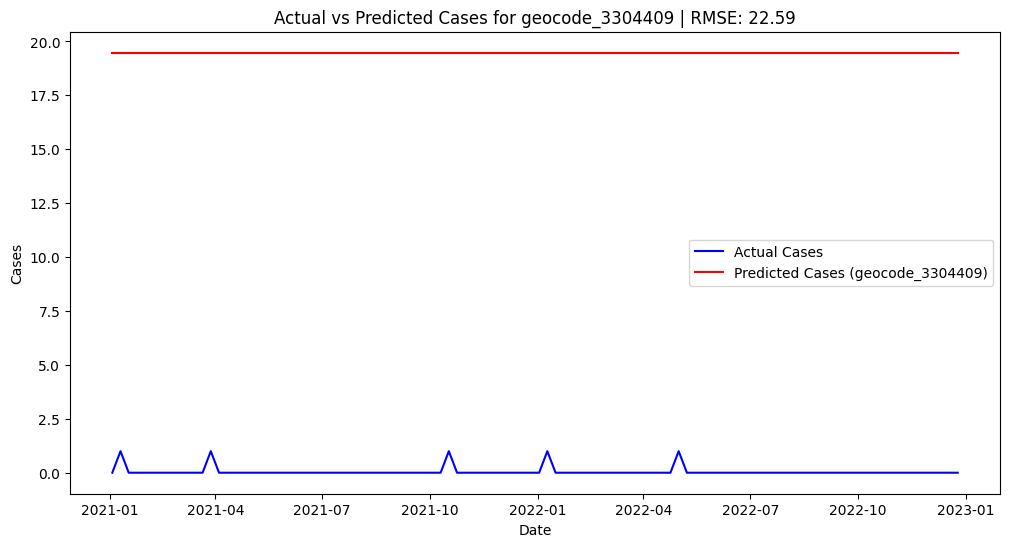

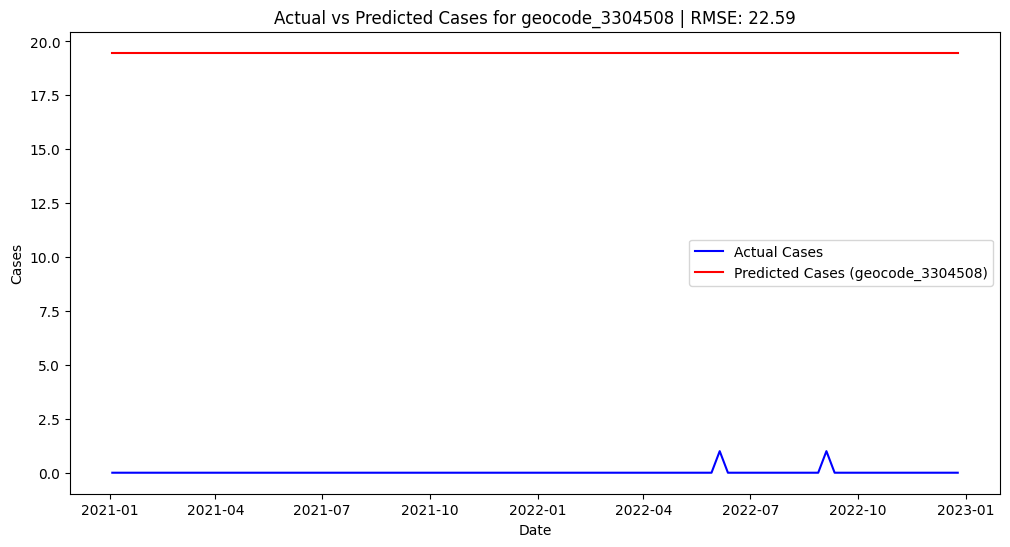

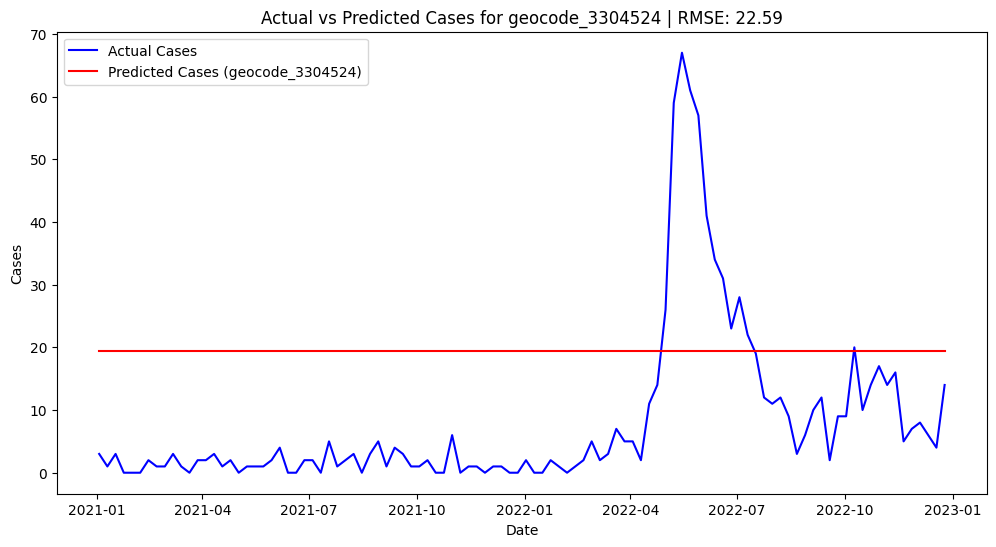

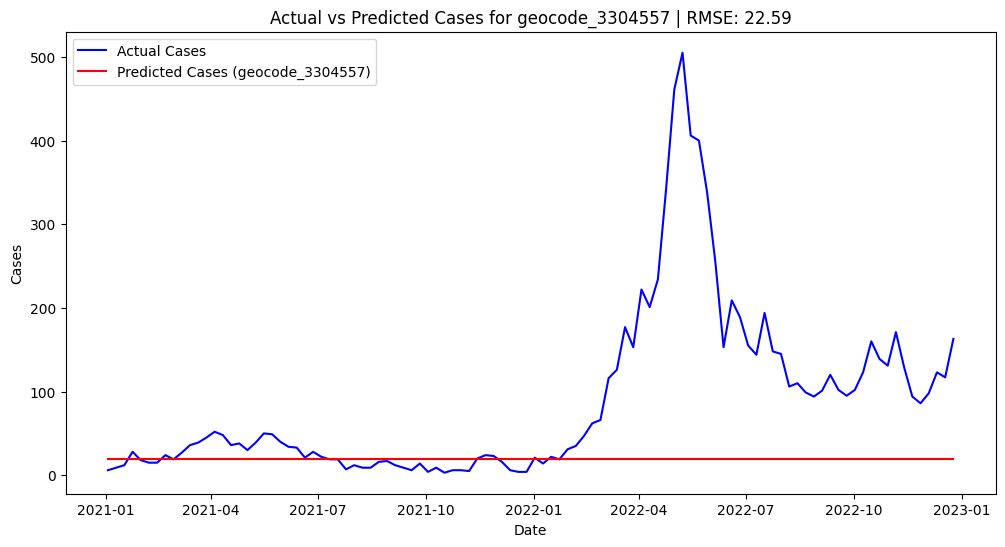

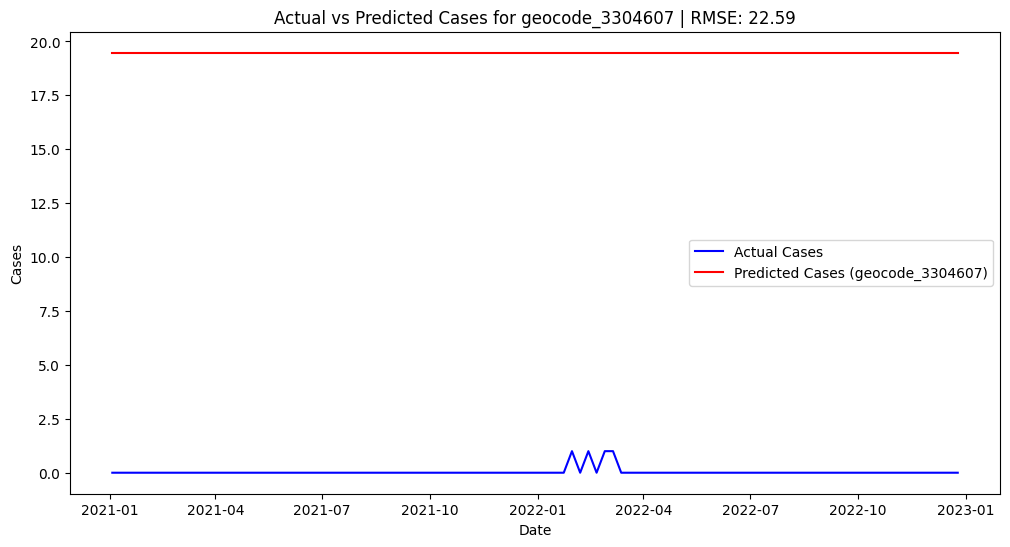

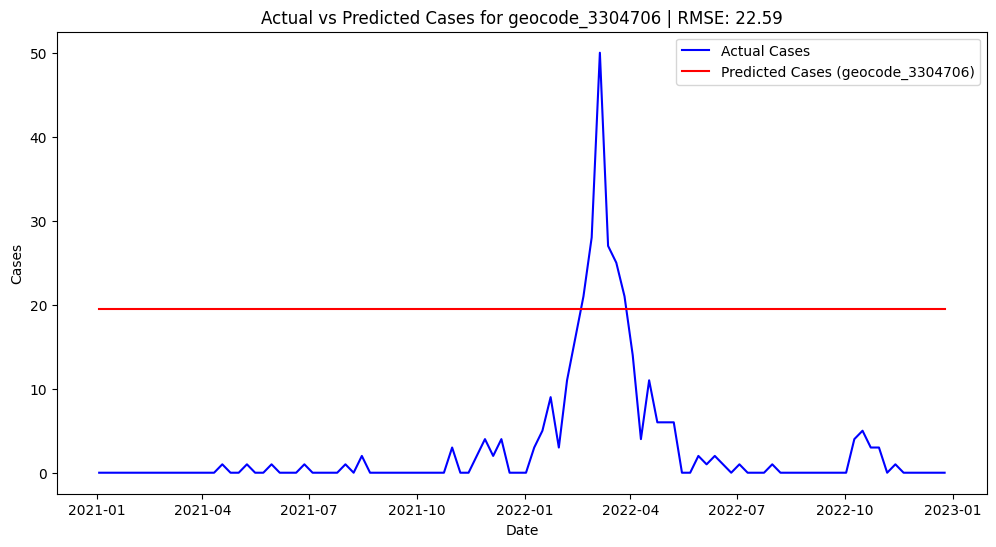

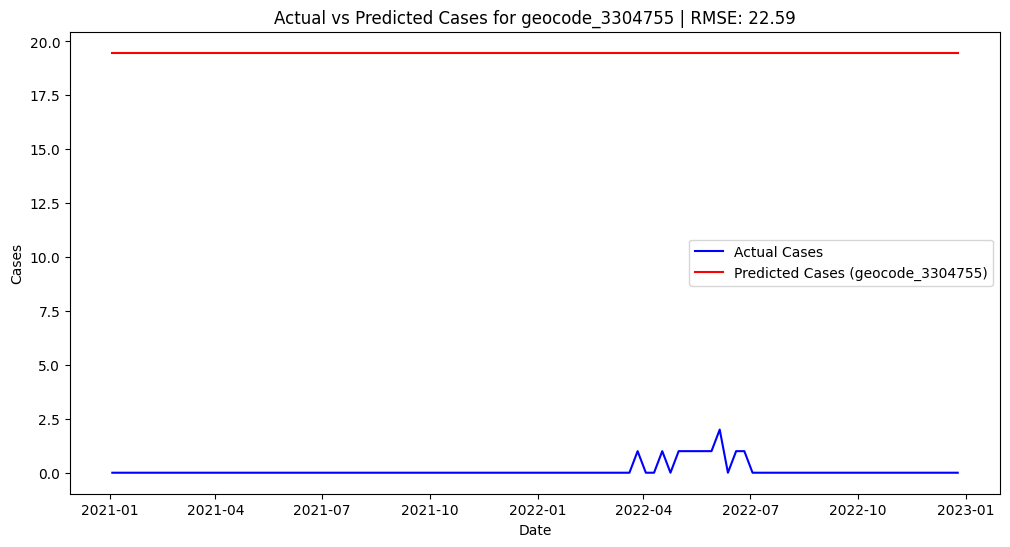

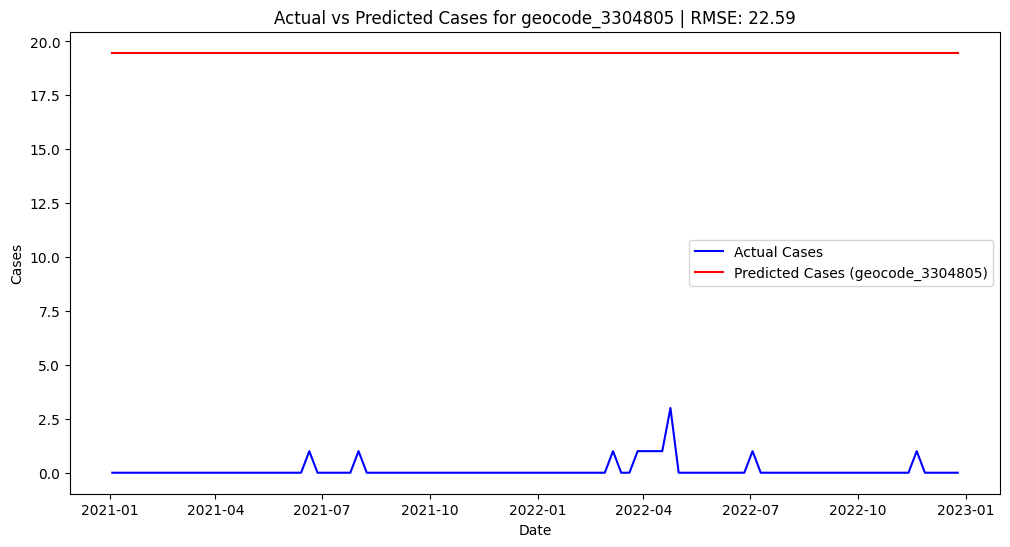

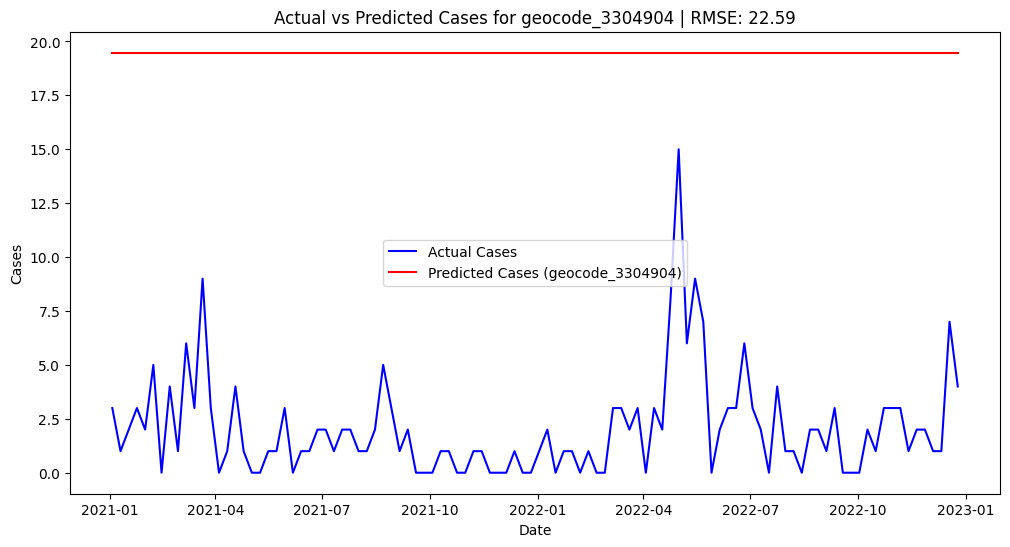

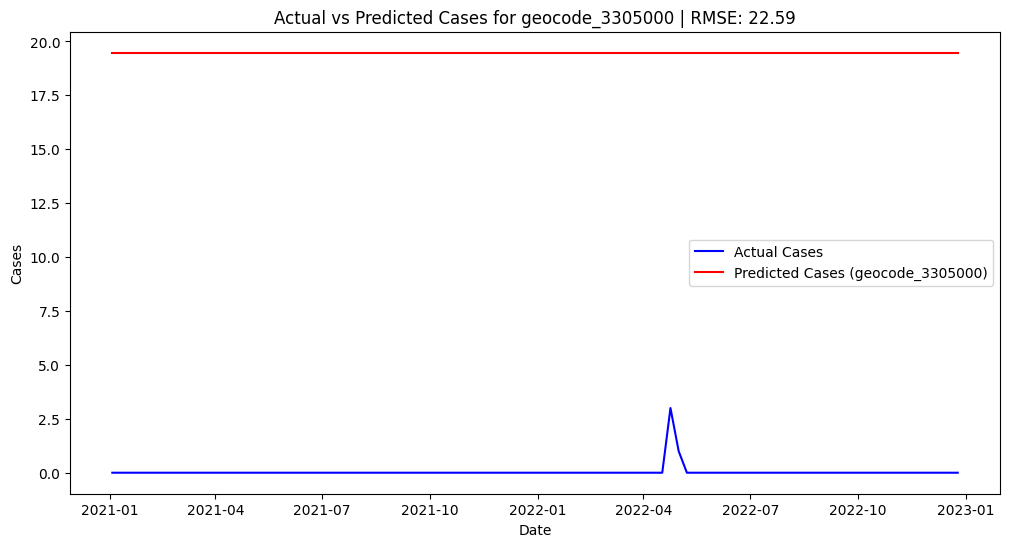

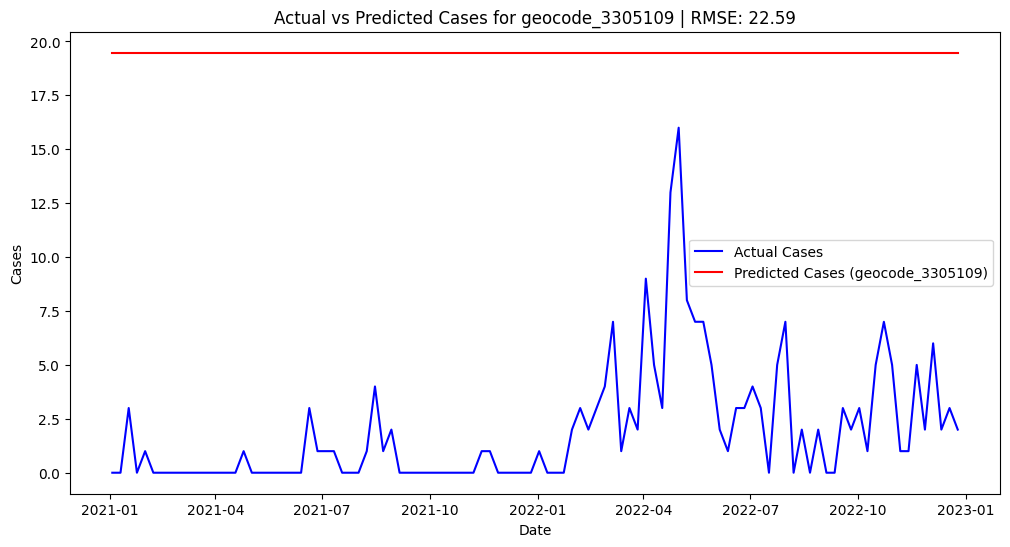

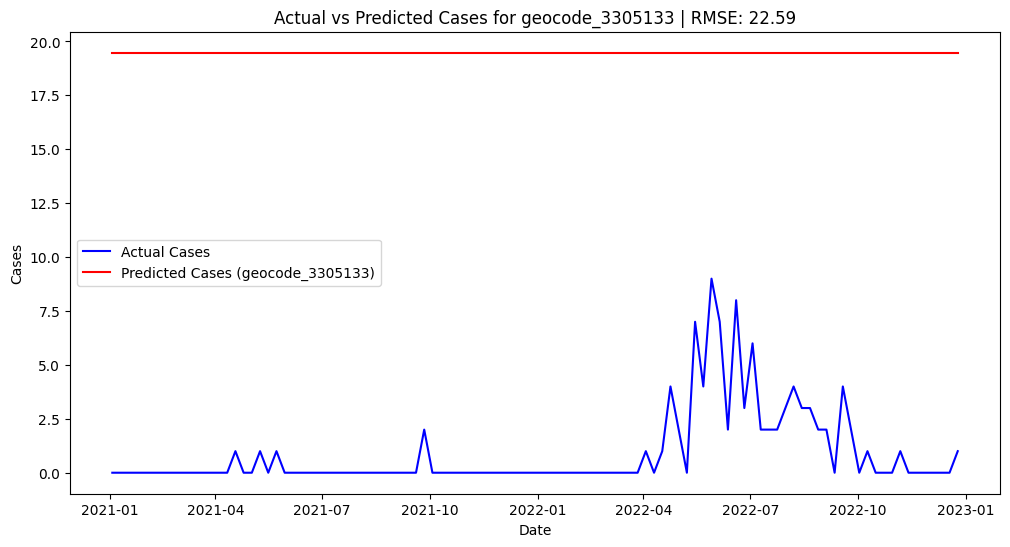

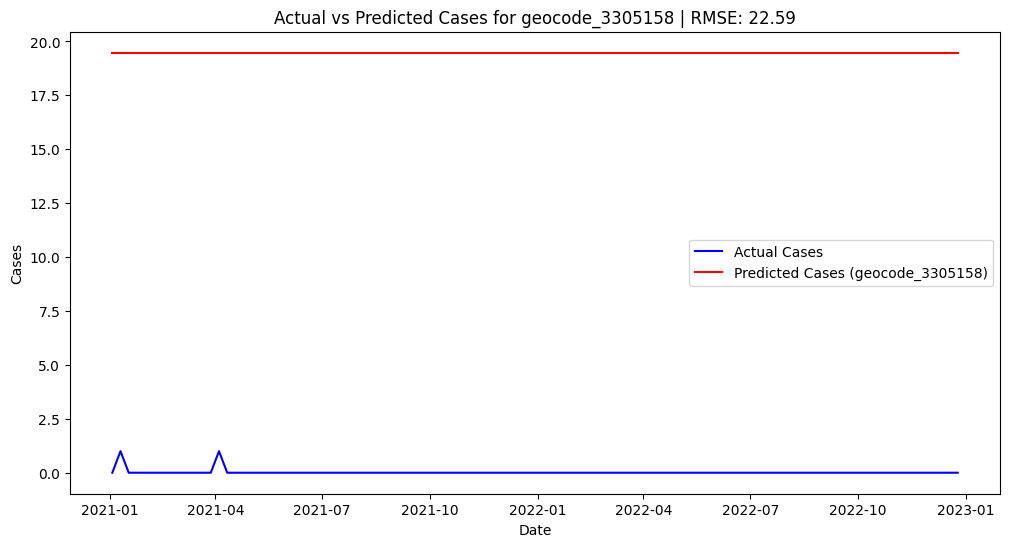

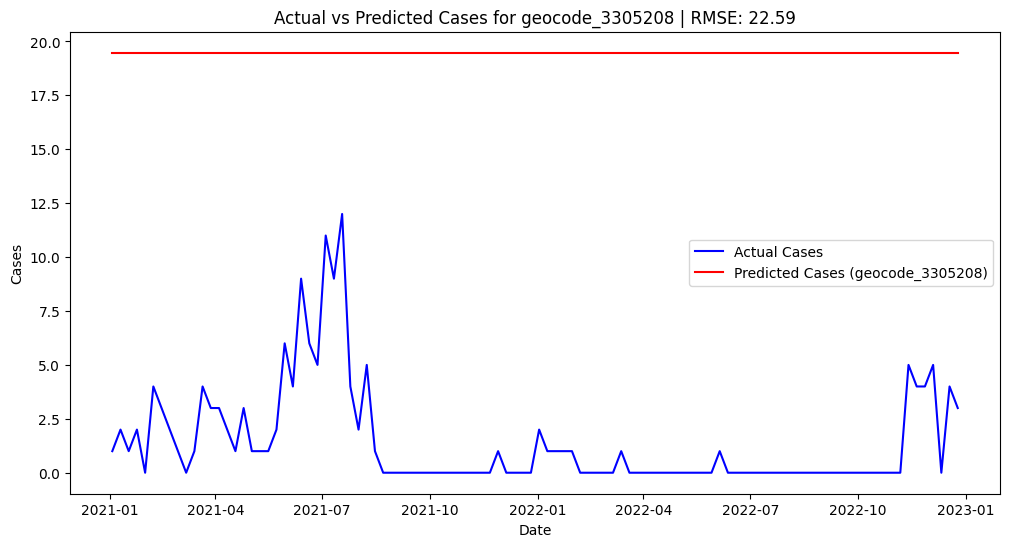

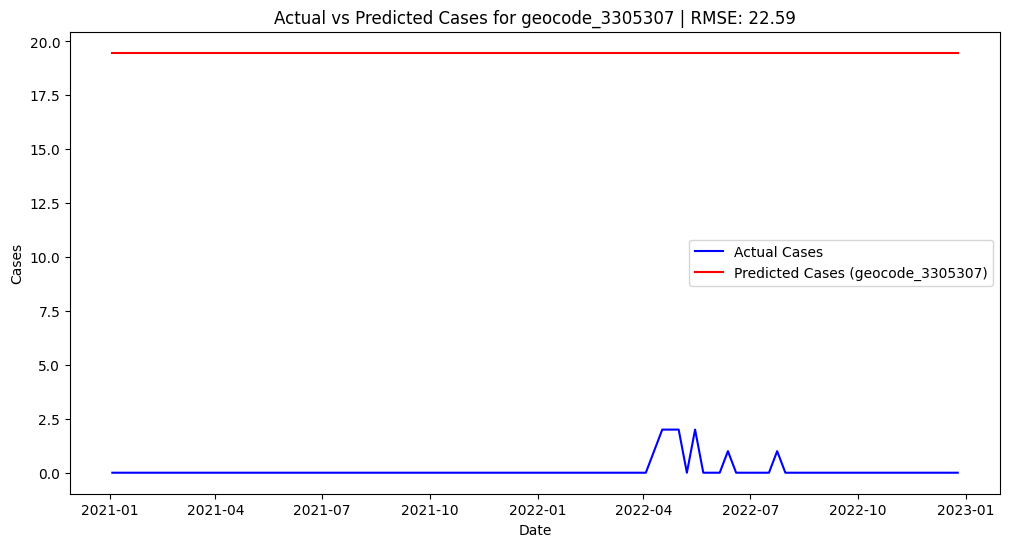

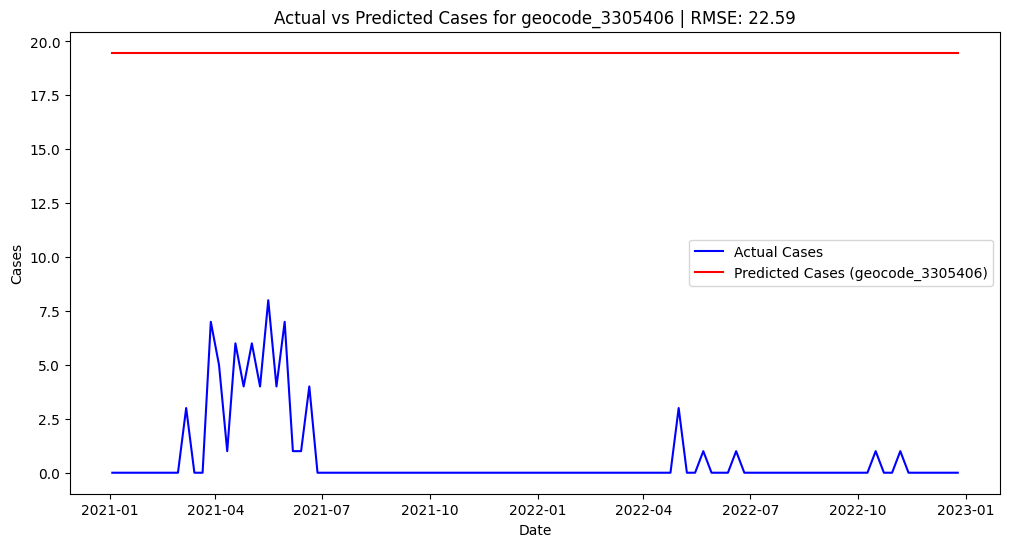

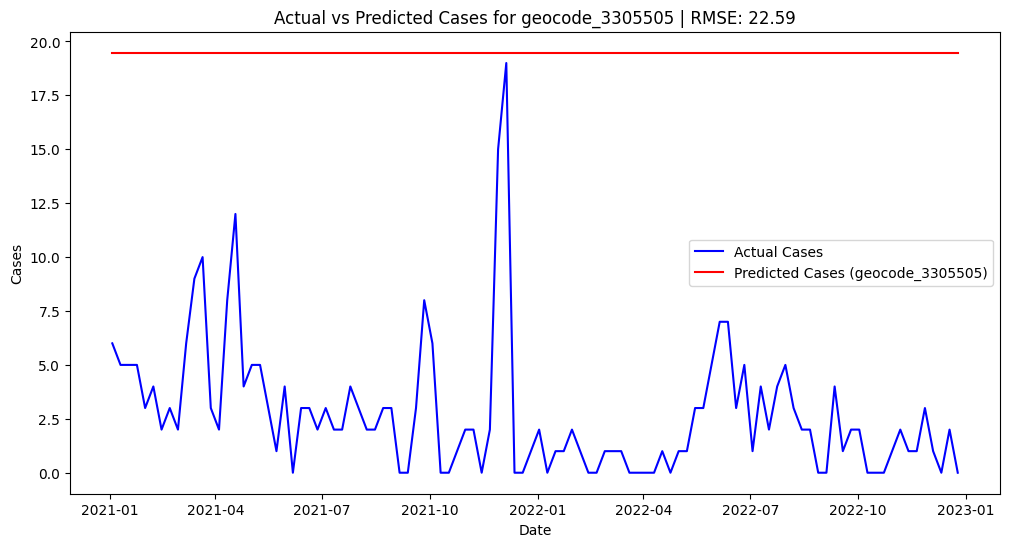

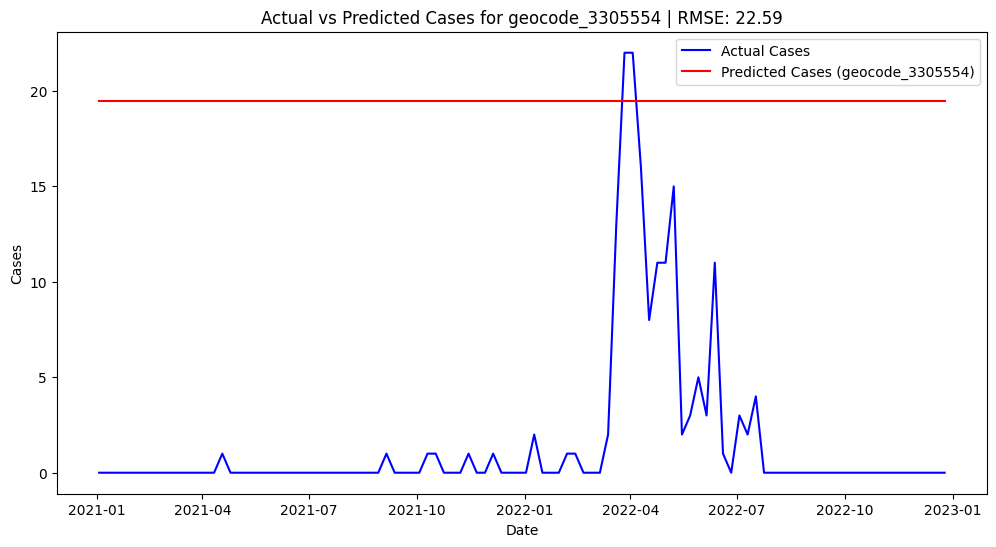

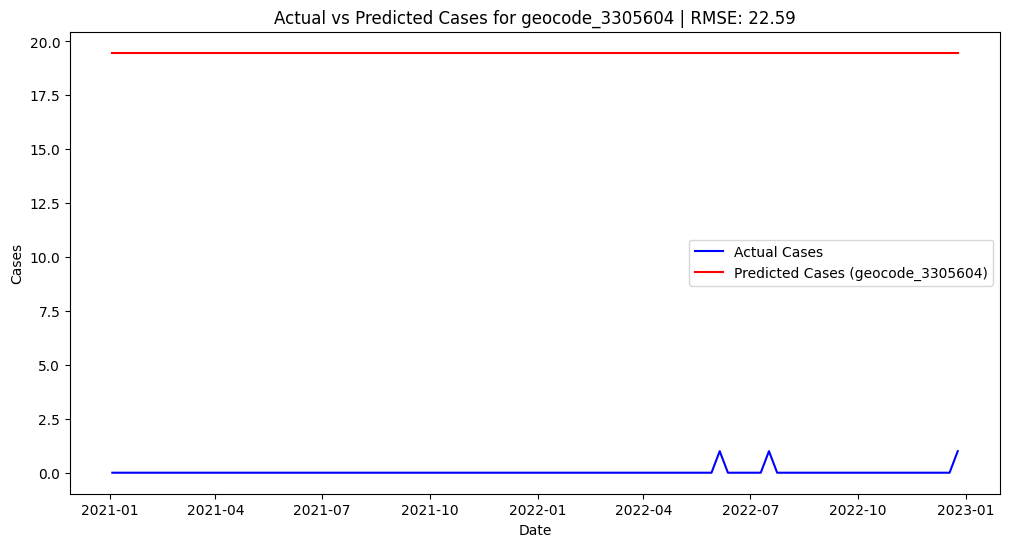

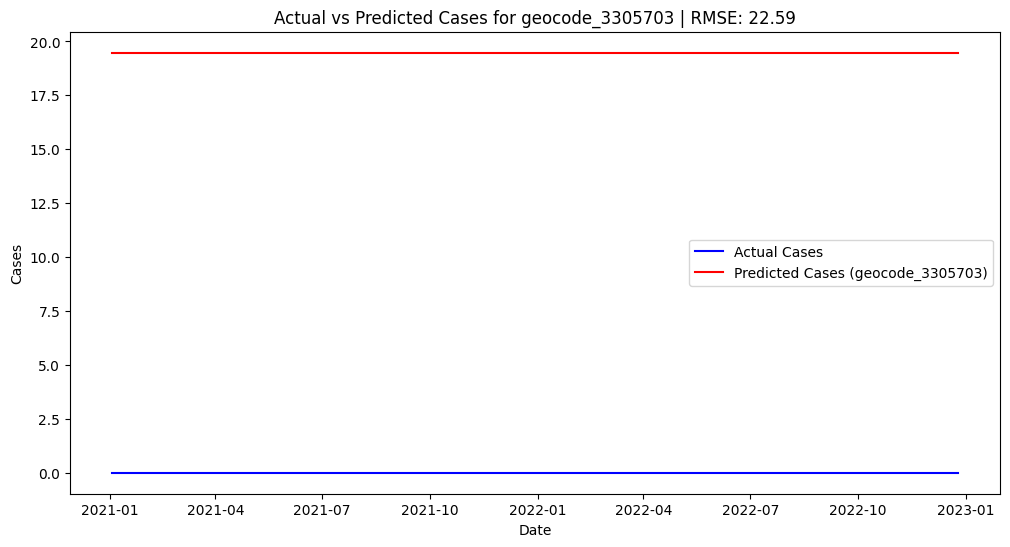

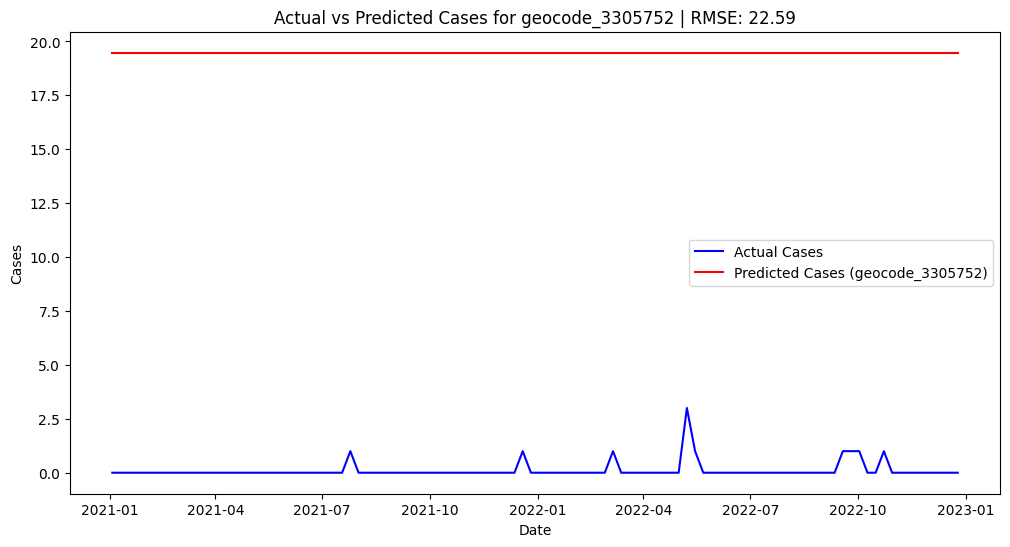

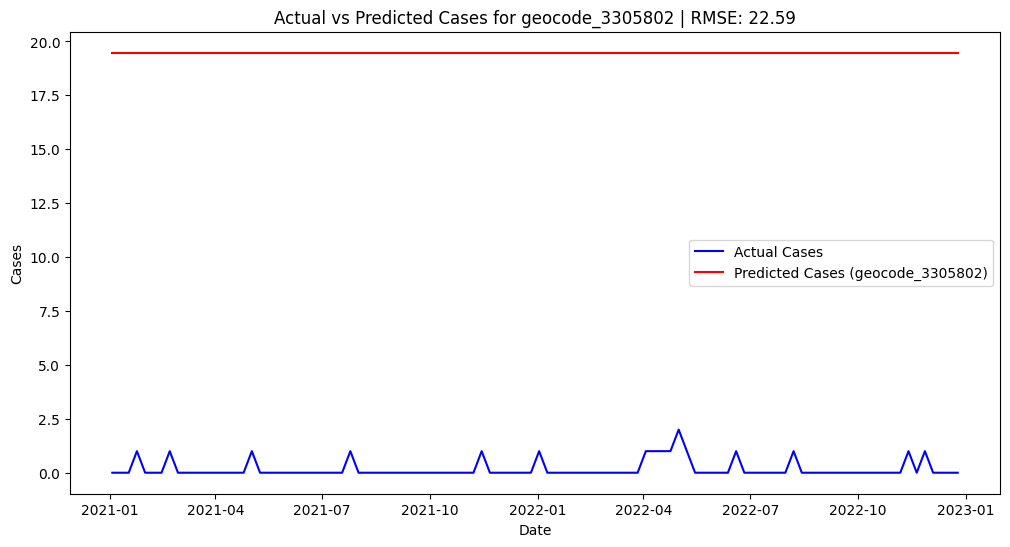

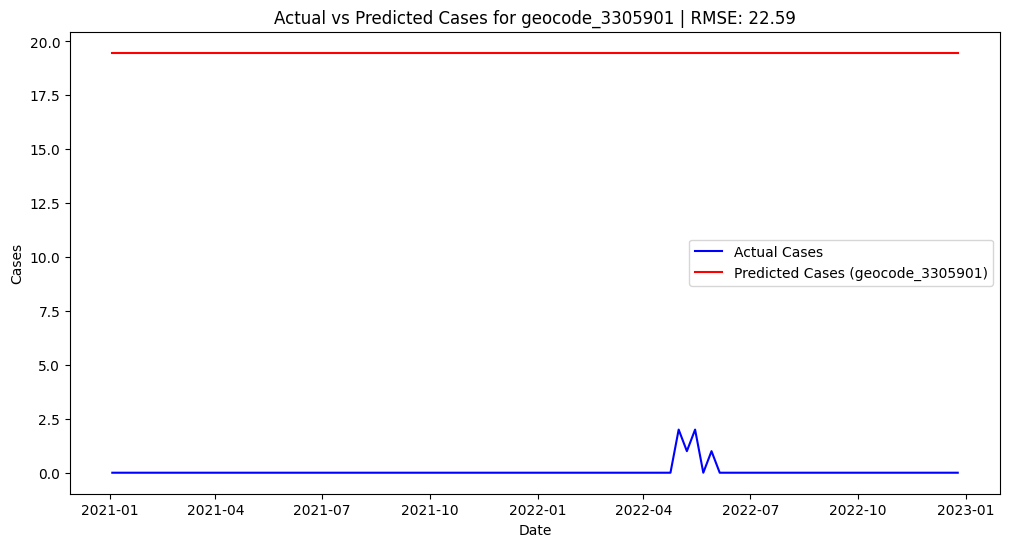

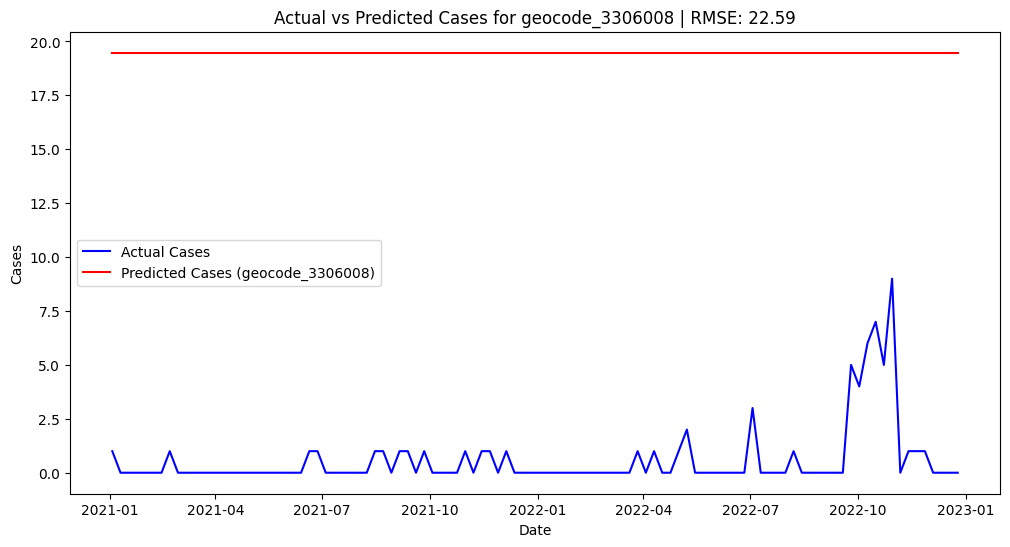

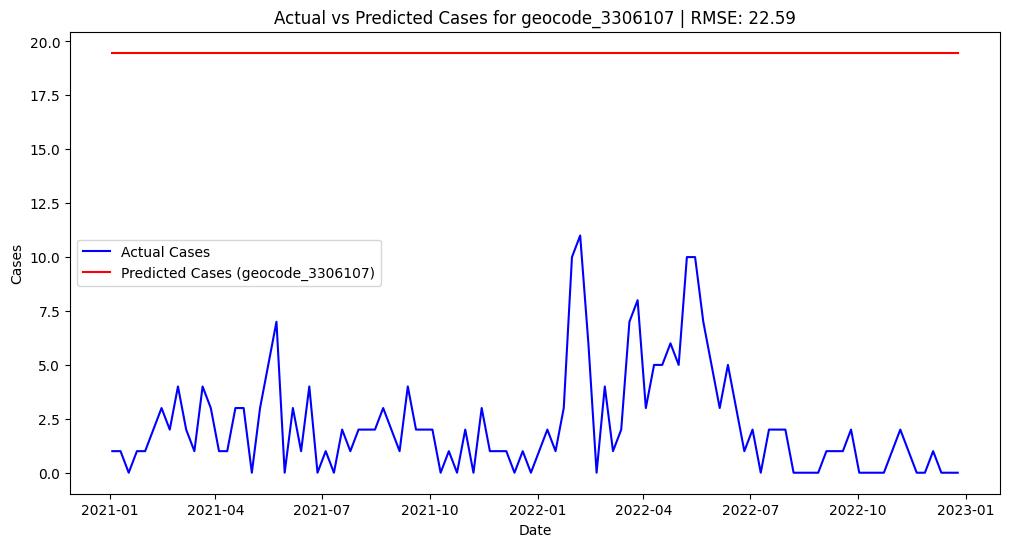

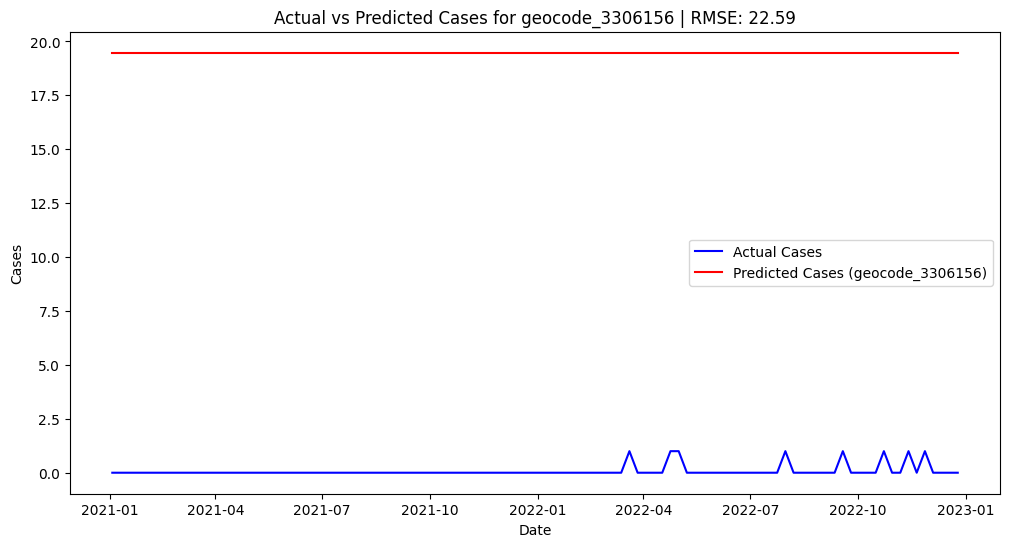

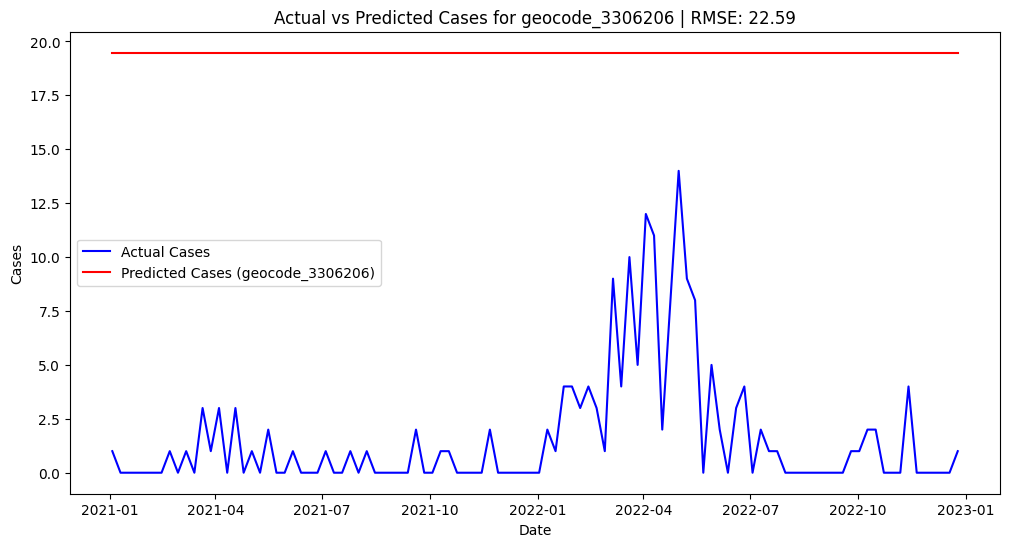

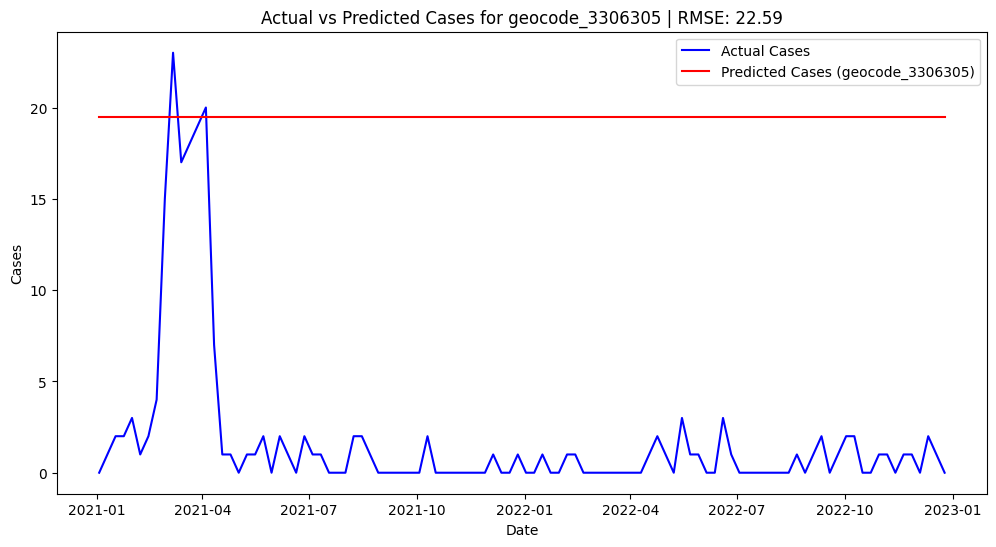

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('final_combined_dataset.csv')

# Drop unnecessary columns and ensure 'date' is in datetime format
df = df.drop(columns=['city', 'week', 'population', 'tempe_min', 'humidity_max', 'humidity_min', 
                      'temp_max', 'vim', 'vim_monthly', 'precipitation_max_ordinary_kriging', 
                      'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging', 
                      'long', 'lat', 'cases_per_100k', 'nearby_cases_weighted', 'precipitation_avg_ordinary_kriging'])
df['date'] = pd.to_datetime(df['date'])

# Create the exogenous variable (geocode one-hot encoding)
df = pd.get_dummies(df, columns=['geocode'], drop_first=True)

# Set the 'date' as the index
df.set_index('date', inplace=True)

# Check for stationarity (ADF test)
result = adfuller(df['cases'])
if result[1] > 0.05:
    print("The series is non-stationary, differencing is needed.")
    df['cases'] = df['cases'].diff().dropna()

# Select multiple endogenous variables (cases, temperature, and humidity as an example)
endog_vars = ['cases', 'temp_avg', 'humidity_avg']  # Add other variables of interest here
train_df = df[df.index.year <= 2020]
test_df = df[df.index.year >= 2021]

# Define the endogenous variables (time series) and exogenous variables (geocode)
train_endog = train_df[endog_vars]  # Multiple endogenous variables now
test_cases = test_df['cases']
X_train = train_df.drop(columns=endog_vars)
X_test = test_df.drop(columns=endog_vars)

# Train the VAR model (using the multiple time series as endogenous variables)
model = VAR(endog=train_endog)
model_fitted = model.fit(maxlags=15, ic='aic')  # Fit with optimal lags based on AIC

# Forecasting the future with the exogenous variables combined into the model
forecast_steps = len(test_cases)
forecast = model_fitted.forecast(y=train_endog.values[-model_fitted.k_ar:], steps=forecast_steps)

# Add exogenous variables to forecast (merge with forecasted values)
forecast_df = pd.DataFrame(forecast, index=test_cases.index, columns=endog_vars)
forecast_df = pd.concat([forecast_df, X_test], axis=1)  # Merge forecast with exogenous variables

# Calculate RMSE for the forecast (using 'cases' for evaluation)
rmse = np.sqrt(mean_squared_error(test_cases, forecast_df['cases']))
print(f"RMSE for VAR model with geocode as exogenous variable: {rmse:.2f}")

# Plot the actual vs predicted values for the entire dataset
plt.figure(figsize=(12, 6))
plt.plot(test_cases.index, test_cases, label='Actual Cases', color='blue')
plt.plot(test_cases.index, forecast_df['cases'], label='Predicted Cases', color='red')
plt.title(f'Actual vs Predicted Cases | RMSE: {rmse:.2f}')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()

# Plot the actual vs predicted values per geocode
geocode_columns = [col for col in X_test.columns if col.startswith('geocode')]

for geocode in geocode_columns:
    # Get the data for this geocode
    geocode_mask = X_test[geocode] == 1
    geocode_cases = test_cases[geocode_mask]
    geocode_forecast = forecast_df[geocode_mask]['cases']  # Only take 'cases' column for forecast

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(geocode_cases.index, geocode_cases, label='Actual Cases', color='blue')
    plt.plot(geocode_cases.index, geocode_forecast, label=f'Predicted Cases ({geocode})', color='red')
    plt.title(f'Actual vs Predicted Cases for {geocode} | RMSE: {rmse:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    plt.show()
